In [1]:
import numpy as np
import pickle as pkl
import h5py
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.ndimage
import pandas as pd
from matplotlib.patches import Ellipse
import os
import sys
sys.path.append('/home/jgalvan/Desktop/Neurocoding/LM_V1_Billeh_model')
from Model_utils import other_billeh_utils
import skimage
from skimage.measure import label, regionprops
from time import time
# # move one directory up 
# os.chdir('..')
%load_ext line_profiler

2025-02-11 17:19:01.885437: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-11 17:19:02.647908: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load data

In [2]:
### STIMULUS PARAMETERS ###
n_trials = 50
col_size = 240
row_size = 120
radius_circle = 10
n_cols =  int(np.ceil((col_size - radius_circle) / radius_circle)) #11
n_rows = int(np.ceil((row_size - radius_circle) / radius_circle)) #13

# Define the time bins 250 ms stim len and calculate the average firing rates for each Gabor patch location
time_bins = np.array([[100, 350], [450, 700], [800, 1050]]) #, [1150, 1400]])
n_timesteps = (time_bins[0,1] - time_bins[0,0]) + (time_bins[1,1] - time_bins[1,0]) + (time_bins[2,1] - time_bins[2,0]) #+ (time_bins[3,1] - time_bins[3,0])

### NETWORK CONFIGURATION ### 
n_core_neurons_v1 = 51978
n_core_neurons_lm = 7414
n_lgn_units = 17400
lm_to_v1_radius_ratio = 400/151.07
# load the network parameters
cache_path = '/home/jgalvan/Desktop/Neurocoding/LM_V1_Billeh_model/Model_utils/.cache/lm_v1_network_v1_100000_lm_30000.pkl'
with open(cache_path, 'rb') as f:
    networks, lgn_inputs, bkg_inputs = pkl.load(f)

### V1 NETWORK INFORMATION ###
v1_core_mask = other_billeh_utils.isolate_core_neurons(networks['v1'], n_selected_neurons=n_core_neurons_v1, data_dir='GLIF_network')
v1_azimuth_core = networks['v1']['x'][v1_core_mask] * 70/1000 + 120
v1_elevation_core = networks['v1']['z'][v1_core_mask] * 40/1000 + 60
# obtain an array with all neurons positions
v1_visual_coordinates = np.array([v1_azimuth_core, v1_elevation_core]).T
# obtain the neuron type of each neuron 
v1_pop_names = other_billeh_utils.pop_names(networks['v1'], n_selected_neurons=n_core_neurons_v1)
v1_cell_types = [other_billeh_utils.pop_name_to_cell_type(pop_name) for pop_name in v1_pop_names]
# Get the mapping between column and core neurons ids
n_v1_neurons = len(v1_core_mask)
v1_core_id_tf_id = np.arange(n_v1_neurons)[v1_core_mask]
v1_tf_id_core_id = np.full(n_v1_neurons, -1)
v1_tf_id_core_id[v1_core_id_tf_id] = np.arange(n_core_neurons_v1)

### LM NETWORK INFORMATION ###	
lm_core_mask = other_billeh_utils.isolate_core_neurons(networks['lm'], n_selected_neurons=n_core_neurons_lm, data_dir='GLIF_network')
lm_azimuth_core = networks['lm']['x'][lm_core_mask] * lm_to_v1_radius_ratio * 70/1000 + 120
lm_elevation_core = networks['lm']['z'][lm_core_mask] * lm_to_v1_radius_ratio * 40/1000 + 60
# obtain an array with all neurons positions
lm_visual_coordinates = np.array([lm_azimuth_core, lm_elevation_core]).T
# obtain the neuron type of each neuron
lm_pop_names = other_billeh_utils.pop_names(networks['lm'], n_selected_neurons=n_core_neurons_lm)
lm_cell_types = [other_billeh_utils.pop_name_to_cell_type(pop_name) for pop_name in lm_pop_names]
# Get the mapping between column and core neurons ids
n_lm_neurons = len(lm_core_mask)
lm_core_id_tf_id = np.arange(n_lm_neurons)[lm_core_mask]
lm_tf_id_core_id = np.full(n_lm_neurons, -1)
lm_tf_id_core_id[lm_core_id_tf_id] = np.arange(n_core_neurons_lm)

### Simulation data

In [14]:
# results path 
data_file = '/home/jgalvan/Desktop/Neurocoding/LM_V1_Billeh_model/Simulation_results/v1_100000_lm_30000/b_gvbz/Best_model/ckpt-240_results/connected_areas_True_conn_rec_True_conn_noise_True/Receptive_field_10x10/Data/simulation_data.hdf5'

# data_file = '/home/jgalvan/Desktop/Neurocoding/LM_V1_Billeh_model/Simulation_results/v1_100000_lm_30000/b_hfm3/Best_model/ckpt-49_results/Receptive_field/Data/simulation_data.hdf5'
# data_file = '/home/jgalvan/Desktop/Neurocoding/LM_V1_Billeh_model/Simulation_results/v1_100000_lm_30000/b_3514_mnist/Best_model/ckpt-5_results/Receptive_field/Data/simulation_data.hdf5'

# Load the data for all trials and locations
v1_spikes = np.zeros((n_rows, n_cols, n_trials, n_core_neurons_v1), dtype=np.float32) # sum of all spikes per neuron and position
lm_spikes = np.zeros((n_rows, n_cols, n_trials, n_core_neurons_lm), dtype=np.float32) # sum of all spikes per neuron and position
lgn_spikes = np.zeros((n_rows, n_cols, n_trials, n_lgn_units), dtype=np.float32) # sum of all spikes per neuron and position

with h5py.File(data_file, 'r') as data:
    for col in tqdm(range(n_cols)):
        for row in range(n_rows):
            name = str(row)+'_'+str(col)
            # Load v1, lm, and LGN data in one go
            t0 = time()
            v1 = np.array(data['Data']['v1'][name][:], dtype=np.float32)
            lm = np.array(data['Data']['lm'][name][:], dtype=np.float32)
            lgn = np.array(data['Data']['LGN'][name][:], dtype=np.float32)
            # LGN = data['Data']['LGN'][name][:]
            v1_spikes[row, col, :, :] = v1
            lm_spikes[row, col, :, :] = lm
            lgn_spikes[row, col, :, :] = lgn

# Get the total spikes in all trials
v1_total_spikes = np.sum(v1_spikes, axis=2)
lm_total_spikes = np.sum(lm_spikes, axis=2)
lgn_total_spikes = np.sum(lgn_spikes, axis=2)

# normalize v1 with the number of trials and time bins to get an average firing rate per neuron, multiply by 1000 to get Hz
v1_fr = v1_total_spikes / (n_trials * n_timesteps) * 1000
lm_fr = lm_total_spikes / (n_trials * n_timesteps) * 1000
# v1_fr_dis = v1_total_spikes_dis / (n_trials * n_timesteps) * 1000
lgn_fr = lgn_total_spikes / (n_trials * n_timesteps) * 1000

100%|██████████| 23/23 [00:13<00:00,  1.71it/s]


In [15]:
v1_fr.shape, lm_fr.shape, np.mean(v1_fr), np.mean(lm_fr)

((11, 23, 51978), (11, 23, 7414), 4.060338, 3.669563)

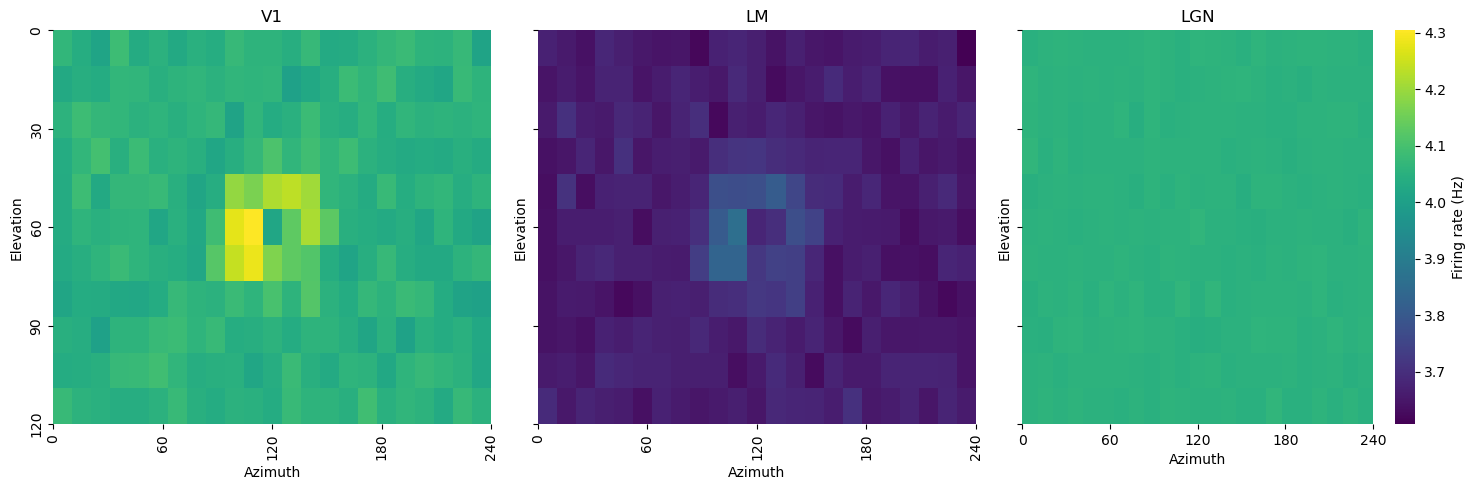

In [16]:
# Compute the global vmin and vmax for shared colorbar scale
all_data = [np.mean(v1_fr, axis=-1), np.mean(lm_fr, axis=-1), np.mean(lgn_fr, axis=-1)]
vmin = min(data.min() for data in all_data)
vmax = max(data.max() for data in all_data)

# Create a subplots figure to show the V1, LM, and LGN receptive fields
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

# Define the azimuth and elevation coordinates
azimuth_ticks = np.linspace(0, v1_fr.shape[1], 5)  # Adjust based on data shape
azimuth_labels = np.linspace(0, 240, 5, dtype=int)
elevation_ticks = np.linspace(0, v1_fr.shape[0], 5)  # Adjust based on data shape
elevation_labels = np.linspace(0, 120, 5, dtype=int)

sns.heatmap(np.mean(v1_fr, axis=-1), cmap='viridis', cbar=False, ax=axs[0], vmin=vmin, vmax=vmax)
axs[0].set_title('V1')
sns.heatmap(np.mean(lm_fr, axis=-1), cmap='viridis', cbar=False, ax=axs[1], vmin=vmin, vmax=vmax)
axs[1].set_title('LM')
sns.heatmap(np.mean(lgn_fr, axis=-1), cmap='viridis', cbar=True, ax=axs[2], vmin=vmin, vmax=vmax)
axs[2].set_title('LGN')

# Add title to the colorbar
cbar = axs[2].collections[0].colorbar
cbar.set_label('Firing rate (Hz)')

# Change the x and y labels and set ticks to match azimuth and elevation coordinates
for ax in axs:
    ax.set_xlabel('Azimuth')
    ax.set_ylabel('Elevation')
    ax.set_xticks(azimuth_ticks)
    ax.set_xticklabels(azimuth_labels)
    ax.set_yticks(elevation_ticks)
    ax.set_yticklabels(elevation_labels)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

<Axes: >

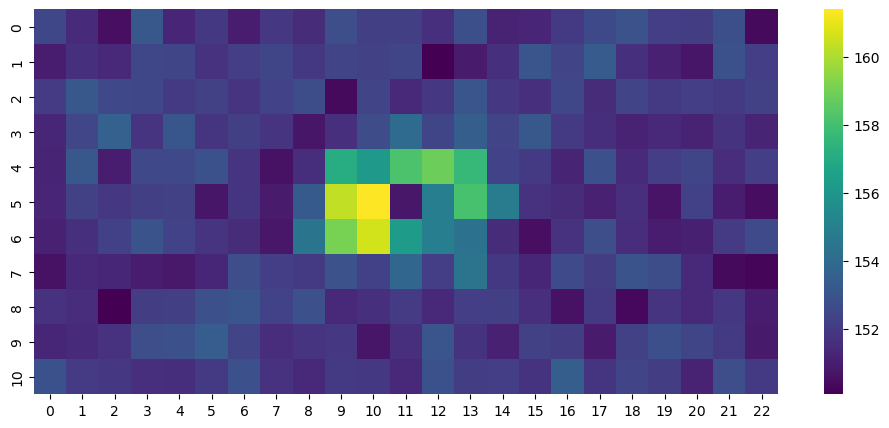

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(12, 5), sharex=True, sharey=True)

sns.heatmap(np.mean(v1_total_spikes, axis=-1), cmap='viridis', cbar=True, ax=axs) #, vmin=vmin, vmax=vmax)

<Axes: >

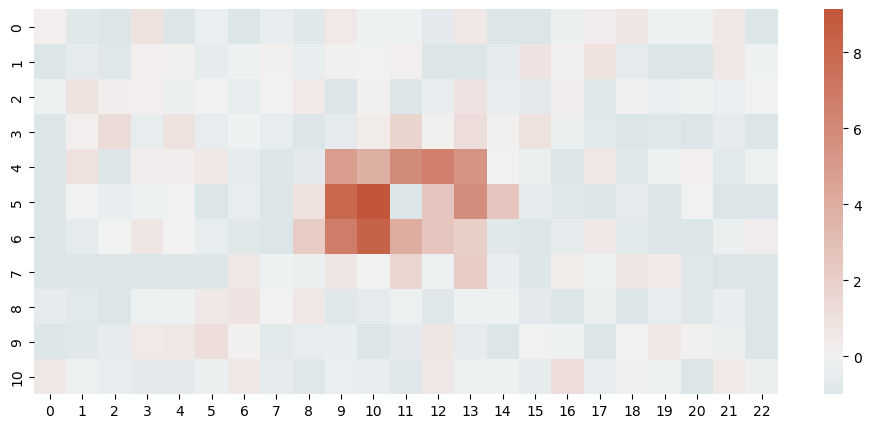

In [18]:
fig, axs = plt.subplots(1, 1, figsize=(12, 5), sharex=True, sharey=True)

deviations = np.mean(v1_total_spikes, axis=-1) - np.mean(v1_total_spikes)
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Determine the maximum absolute deviation for symmetric color scaling
max_deviation = np.max(np.abs(deviations))

# Plot the heatmap with the diverging colormap centered at 0
sns.heatmap(deviations, cmap=cmap, cbar=True, ax=axs, center=0, vmin=-1, vmax=max_deviation)

# Plot RF individual neurons

In [19]:
import scipy.ndimage as ndi

def is_rf_inverted_siegle(rf_thresh):
    """Checks if the receptive field mapping stimulus is suppressing
    or exciting the cell

    Parameters
    ----------
    rf_thresh : matrix
        matrix of spike counts at each stimulus position

    Returns
    -------
    if_rf_inverted : bool
        True if the receptive field is inverted
    """
    edge_mask = np.zeros(rf_thresh.shape)

    edge_mask[:, 0] = 1
    edge_mask[:, -1] = 1
    edge_mask[0, :] = 1
    edge_mask[-1, :] = 1

    num_edge_pixels = np.sum(rf_thresh * edge_mask)

    return num_edge_pixels > np.sum(edge_mask) / 2

def is_rf_inverted_sofia(total_spike_count, expected_fr):
    ### IDENTIFY OUTLIERS IN THE FRs AND PLOT THE RF ###
    # set 0.0 values to percentile median
    expected_value = np.median(total_spike_count)
    # total_spike_count[np.round(total_spike_count) == 0.0] = expected_value
    total_spike_count[expected_fr < 0.1] = expected_value
    # Recalculate the expected value
    expected_value = np.median(total_spike_count)
    # Recalculate the std and mad
    std = np.std(total_spike_count)
    mad = np.median(np.abs(total_spike_count - expected_value))

    above_std = total_spike_count[total_spike_count > expected_value + mad*3.5]
    below_std = total_spike_count[total_spike_count < expected_value - mad*3.5]
    outliers = np.concatenate((above_std, below_std))

    # create two new binary heatmaps
    above_std_map_binary = np.zeros_like(total_spike_count)
    below_std_map_binary = np.zeros_like(total_spike_count)

    if len(above_std) > 0:
        for i in range(len(above_std)):
            idx = np.where(total_spike_count == above_std[i])
            above_std_map_binary[idx] = 1

        # labelling connected components
        above_std_map = skimage.measure.label(above_std_map_binary)
        # get the largest connected component of each map
        above_std_map = (above_std_map == np.argmax(np.bincount(above_std_map.flat)[1:]) + 1)
        # get the list of positions
        above_std_positions_largest = np.where(above_std_map == 1)
        # print the positions
        # print('Positions above std:', above_std_positions_largest)
        # compare lengths of above and below std
        # print('Length above std:', len(above_std_positions_largest[0]))
    else:
        above_std_positions_largest = [[]]

    if len(below_std) > 0:
        for i in range(len(below_std)):
            idx = np.where(total_spike_count == below_std[i])
            below_std_map_binary[idx] = 1

        below_std_map = skimage.measure.label(below_std_map_binary)
        below_std_map = (below_std_map == np.argmax(np.bincount(below_std_map.flat)[1:]) + 1)
        below_std_positions_largest = np.where(below_std_map == 1)
        # print('Positions below std:', below_std_positions_largest)
        # print('Length below std:', len(below_std_positions_largest[0]))
    else:
        below_std_positions_largest = [[]]

    if len(below_std_positions_largest[0]) > len(above_std_positions_largest[0]):
        inverse = True
        # print('Inverse RF')
    else:
        inverse = False
        # print('Non-inverse RF')

    return inverse

def identify_outliers(rf):
    """Create a binary map for the outliers using the interquartile method."""
    q1 = np.percentile(rf, 25)  # First quartile (25th percentile)
    q3 = np.percentile(rf, 75)  # Third quartile (75th percentile)
    iqr = q3 - q1
    # Define thresholds
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    # Identify outliers
    above_outliers = rf[rf > upper_bound]
    below_outliers = rf[rf < lower_bound]
    return above_outliers, below_outliers

def process_connected_components(binary_map):
    """Process connected components and find the largest one."""
    labeled_map = label(binary_map)
    regions = regionprops(labeled_map)
    if regions:
        largest_region = max(regions, key=lambda r: r.area)
        largest_map = (labeled_map == largest_region.label)
        positions = np.where(largest_map)
        return largest_map, positions
    return np.zeros_like(binary_map), ([], [])

def is_rf_inverted(rf):
    # Identify outliers
    above_outliers, below_outliers = identify_outliers(rf)
    # outliers = np.concatenate((above_outliers, below_outliers))
    # Create binary maps for each of the outliers
    above_binary_map = np.isin(rf, above_outliers).astype(int)
    below_binary_map = np.isin(rf, below_outliers).astype(int)
    # Process connected components and find the largest one
    _, above_positions = process_connected_components(above_binary_map)
    _, below_positions = process_connected_components(below_binary_map)
    # Compare lengths of above and below outliers
    if len(below_positions[0]) > len(above_positions[0]):
        inverse = True
    else:
        inverse = False

    return inverse

def get_largest_chi2_value(rf, binary_map):
    expected_value = np.mean(rf)
    # compute residuals
    original_residuals = (rf - expected_value)**2 / (expected_value + 1e-6)
    labels, num_features = ndi.label(binary_map)
    # compute the chi2 value for each cluster as the sum over cluster pixels and choose the one with the largest value
    chi2_values = np.zeros(num_features)
    for i in range(1, num_features + 1):
        cluster_pixels = original_residuals[labels == i]
        chi2_values[i - 1] = np.sum(cluster_pixels)
    if len(chi2_values) == 0:
        return 0
    else:
        return np.max(chi2_values)

def is_rf_inverted_cluster_sum(rf):
    # Identify outliers
    above_outliers, below_outliers = identify_outliers(rf)
    # outliers = np.concatenate((above_outliers, below_outliers))
    # Create binary maps for each of the outliers
    above_binary_map = np.isin(rf, above_outliers).astype(int)
    below_binary_map = np.isin(rf, below_outliers).astype(int)
    # get most significant cluster
    above_chi2 = get_largest_chi2_value(rf, above_binary_map)
    below_chi2 = get_largest_chi2_value(rf, below_binary_map)
    # Compare chi2 values of above and below outliers
    if below_chi2 > above_chi2:
        inverse = True
    else:
        inverse = False

    return inverse

def invert_rf(rf):
    """Creates an inverted version of the receptive field

    Parameters
    ----------
    rf - matrix of spike counts at each stimulus position

    Returns
    -------
    rf_inverted - new RF matrix

    """
    return np.max(rf) - rf

def convert_elevation_to_degrees(
    elevation_in_pixels, n_rows, elevation_offset_degrees=10
):
    """Converts a pixel-based elevation into degrees relative to
    center of gaze

    The receptive field computed by this class is oriented such
    that the pixel values are in the correct relative location
    when using matplotlib.pyplot.imshow(), which places (0,0)
    in the upper-left corner of the figure.

    Therefore, we need to invert the elevation value prior
    to converting to degrees.

    Parameters
    ----------
    elevation_in_pixels : float
    elevation_offset_degrees: float

    Returns
    -------
    elevation_in_degrees : float
    """
    # elevation_in_degrees = (
    #     convert_pixels_to_degrees(n_rows - 1 - elevation_in_pixels)
    #     + elevation_offset_degrees
    # )
    elevation_in_degrees = (
        convert_pixels_to_degrees((elevation_in_pixels)) + elevation_offset_degrees
    )

    return elevation_in_degrees

def convert_azimuth_to_degrees(azimuth_in_pixels, azimuth_offset_degrees=10):
    """Converts a pixel-based azimuth into degrees relative
    to center of gaze

    Parameters
    ----------
    azimuth_in_pixels : float
    azimuth_offset_degrees: float

    Returns
    -------
    azimuth_in_degrees : float
    """
    azimuth_in_degrees = (
        convert_pixels_to_degrees((azimuth_in_pixels)) + azimuth_offset_degrees
    )

    return azimuth_in_degrees

def convert_pixels_to_degrees(value_in_pixels, degrees_to_pixels_ratio=10):
    """Converts a pixel-based distance into degrees

    Parameters
    ----------
    value_in_pixels : float
    degrees_to_pixels_ratio: float

    Returns
    -------
    value in degrees : float
    """
    return value_in_pixels * degrees_to_pixels_ratio

def convert_pixel_area_to_degrees(area_in_pixels):
    """Converts a pixel-based area measure into degrees

    Each pixel is a square with side of length
    <degrees_to_pixels_ratio>

    So the area in degrees is
    area_in_pixels * <degrees to_pixels_ratio>^2

    Parameters
    ----------
    area_in_pixels : float

    Returns
    -------
    area_in_degrees : float
    """
    return area_in_pixels * pow(convert_pixels_to_degrees(1), 2)

In [20]:
# percentage of low responding neurons
np.sum(np.mean(v1_fr, axis=(0,1)) < 0.1)*100/n_core_neurons_v1, np.sum(np.mean(lm_fr, axis=(0,1)) < 0.1)*100/n_core_neurons_lm

(0.03463003578437031, 0.29673590504451036)

Neuron type: L5 Exc
Neuron position: [134.0034    61.231667]
Inverted RF: False
Inverted Cluster RF: False
Non-inverted RF
Hey:  2 2
Centers for neuron 5:  (12.0, 6.5) (12.0, 6.5)


Neuron type: L5 PV
Neuron position: [131.67513   46.921562]
Inverted RF: False
Inverted Cluster RF: False
Non-inverted RF
Hey:  1 1
Centers for neuron 30974:  (12.0, 3.0) (12.0, 3.0)


Neuron type: L5 Exc
Neuron position: [128.77771  50.12686]
Inverted RF: True
Inverted Cluster RF: True
Inverted RF
Hey:  1 1
Centers for neuron 11:  (13.0, 4.0) (13.0, 4.0)


Neuron type: L5 Exc
Neuron position: [113.13113  67.11285]
Inverted RF: False
Inverted Cluster RF: False
Non-inverted RF
Hey:  1 1
Centers for neuron 20:  (10.0, 6.0) (10.0, 6.0)


Neuron type: L2/3 Exc
Neuron position: [129.40678  61.70004]
Inverted RF: False
Inverted Cluster RF: True
Inverted RF
Hey:  1 1
Centers for neuron 13910:  (12.0, 5.0) (12.0, 5.0)




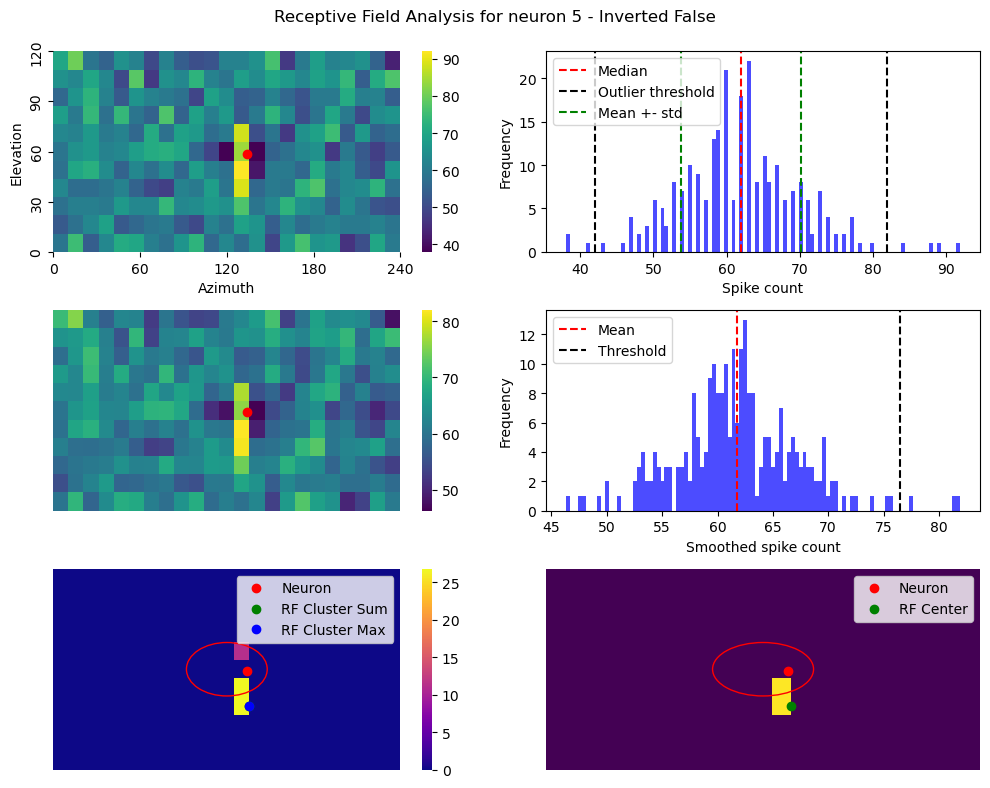

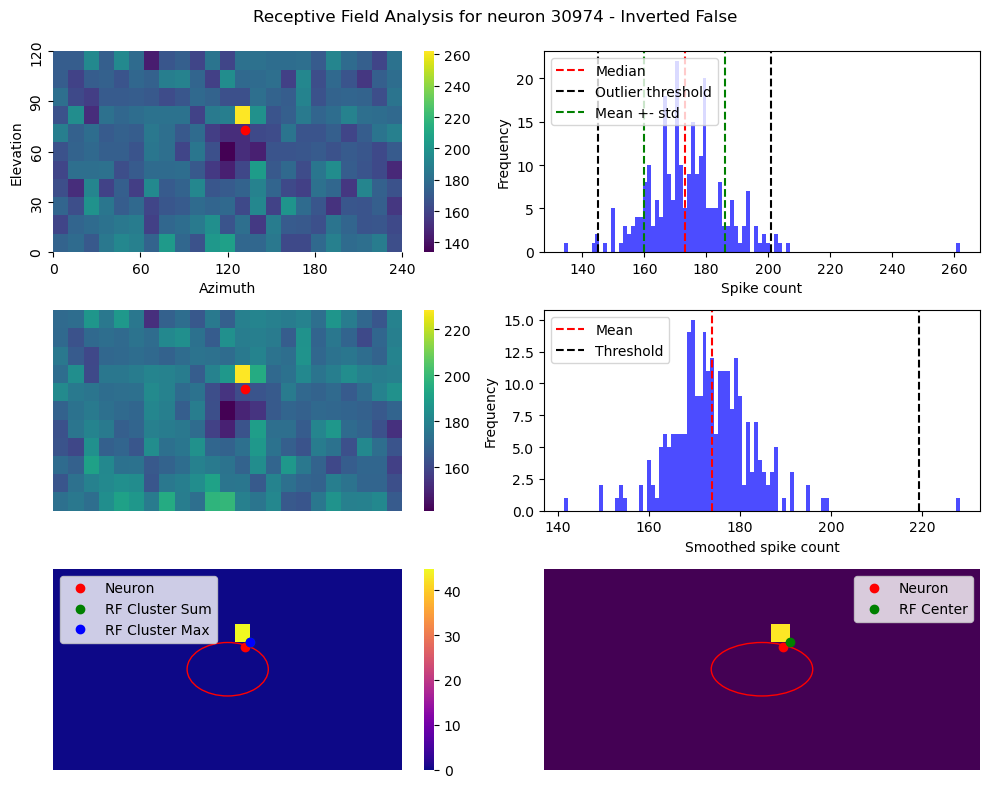

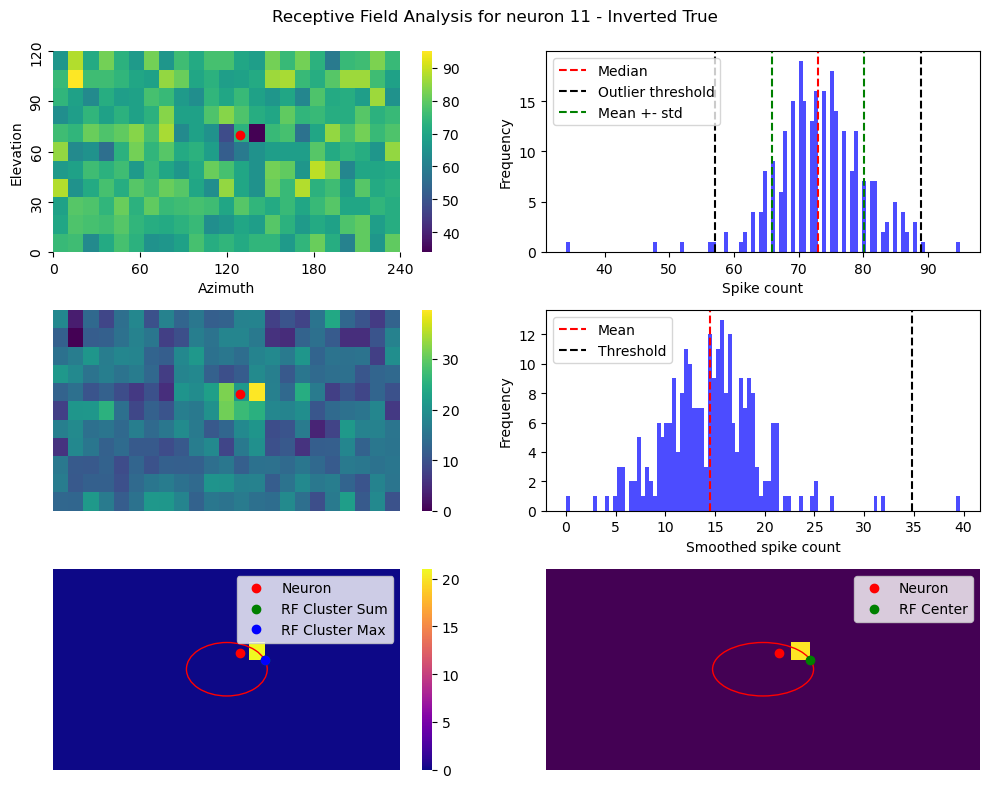

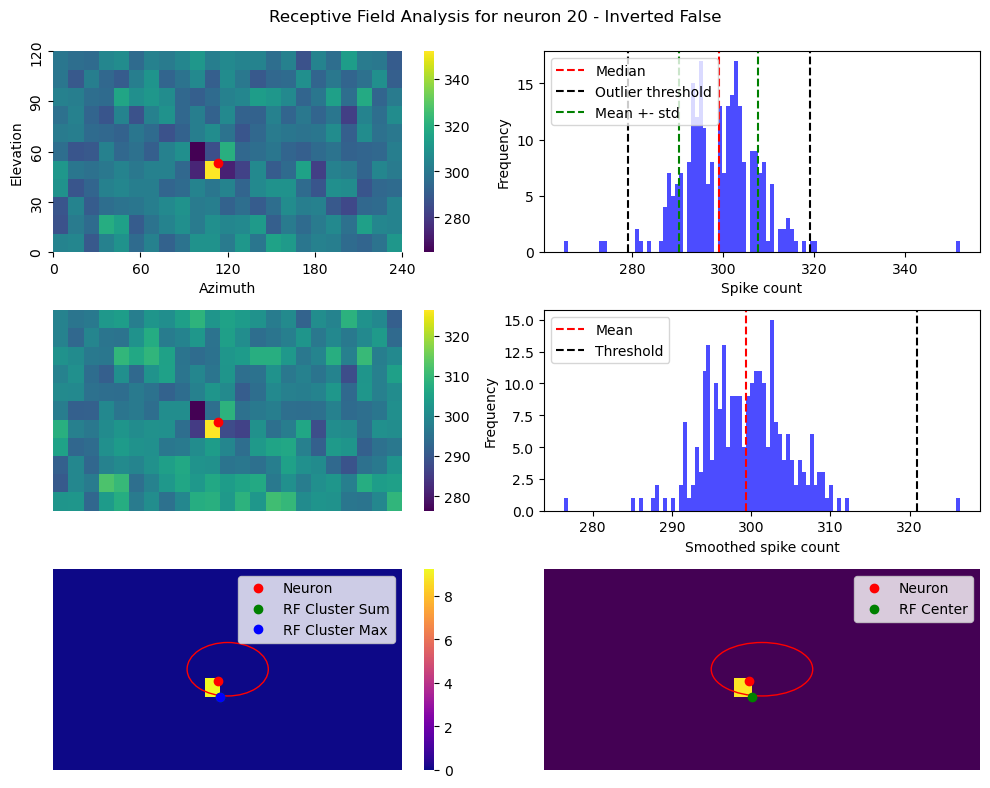

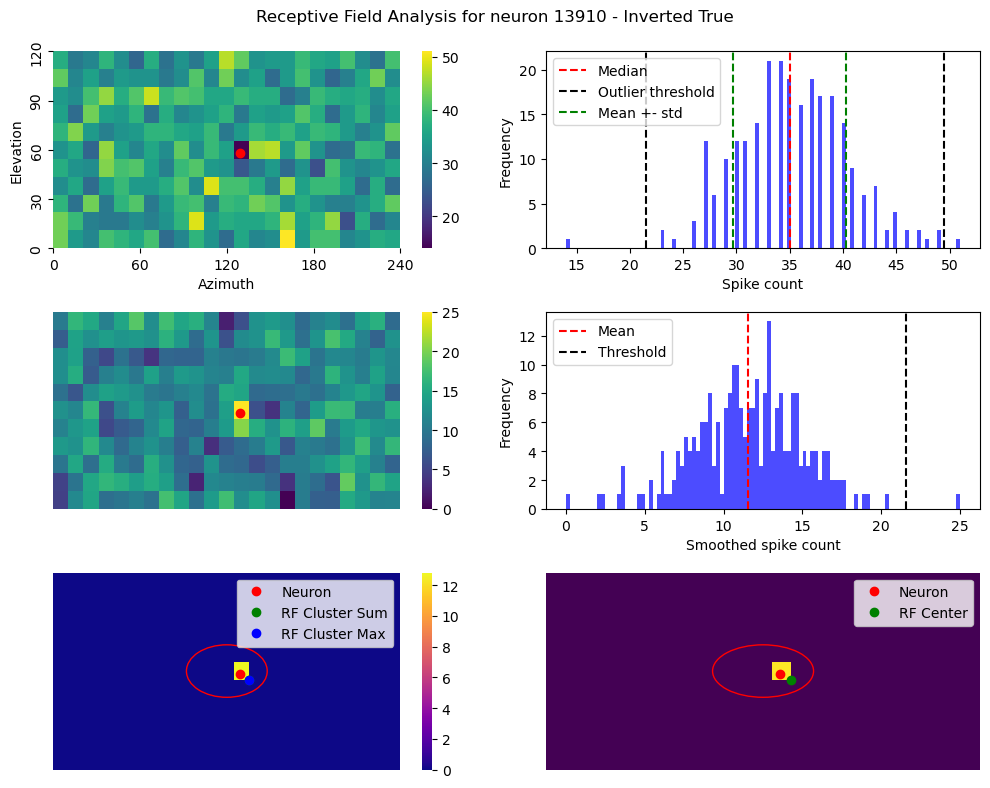

In [22]:
### SELECT A SINGLE NEURON ###
# neuron_id = 5  #2342
for neuron_id in [5, 30974, 11, 20, 13910]:
    neuron_type = v1_cell_types[neuron_id]  
    print('Neuron type:', neuron_type)
    neuron_pos = v1_visual_coordinates[neuron_id, :]
    print('Neuron position:', neuron_pos)
    # get the average firing rate of the neuron
    expected_fr = np.copy(v1_fr[:,:,neuron_id]) # 1
    total_spike_count = np.copy(v1_total_spikes[:,:,neuron_id]) # 1

    if np.mean(expected_fr) < 0.1:
        print('Neuron has a low firing rate, select another neuron')
        # return np.nan for every feature in the df table
        # break

    # Apply the Gaussian filter to the total spike count
    rf_filt = scipy.ndimage.gaussian_filter(total_spike_count, 0.5)
    rf_filt0 = np.copy(rf_filt)

    print('Inverted RF:', is_rf_inverted(total_spike_count))
    print('Inverted Cluster RF:', is_rf_inverted_cluster_sum(total_spike_count))

    if is_rf_inverted_cluster_sum(total_spike_count):
        print('Inverted RF')
        rf_filt = invert_rf(rf_filt)
        inverted = True
    else:
        print('Non-inverted RF')
        inverted = False

    # Apply a threshold to the filtered RF
    threshold_value = np.max(rf_filt) - np.std(rf_filt)
    rf_thresh = np.zeros(total_spike_count.shape, dtype="bool")
    rf_thresh[rf_filt > threshold_value] = True

    # Perform connected component analysis
    labels, num_features = ndi.label(rf_thresh)
    unfiltered_labels = np.copy(labels)
    chi2_labels = np.copy(labels).astype(np.float32)
    expected_value = np.mean(total_spike_count)
    # compute residuals
    original_residuals = (total_spike_count - expected_value)**2 / (expected_value + 1e-6)
    # compute the chi2 value for each cluster as the sum over cluster pixels and choose the one with the largest value
    chi2_values = np.zeros(num_features)
    for i in range(1, num_features + 1):
        cluster_pixels = original_residuals[labels == i]
        chi2_values[i - 1] = np.sum(cluster_pixels)
        chi2_labels[chi2_labels == i] = chi2_values[i - 1]

    if len(chi2_values) > 0:
        best_cluster_index = np.argmax(chi2_values) + 1
    else:
        best_cluster_index = 0

    # Computes the maximum value of rf_filt for each labeled region 
    strongest_label = np.argmax(ndi.maximum(rf_filt, labels=labels, index=np.unique(labels)))
    print('Hey: ', strongest_label, best_cluster_index)

    best_label = best_cluster_index
    labels[labels != best_label] = 0
    labels[labels > 0] = 1
    center_y, center_x = ndi.center_of_mass(labels)
    # this center is located in the upper left corner of the pixel
    center_x = np.around(center_x, 4)
    center_y = np.around(center_y, 4)

    # caluclate the center of the second receptive field
    new_labels = np.copy(unfiltered_labels)
    new_labels[new_labels != strongest_label] = 0
    new_labels[new_labels > 0] = 1
    center_y_unfiltered, center_x_unfiltered = ndi.center_of_mass(new_labels)

    # THIS SHOULD BE CONVERTED TO VISUAL SPACE
    center_azimuth = convert_azimuth_to_degrees(center_x)
    center_elevation = convert_elevation_to_degrees(center_y, n_rows)

    pixels_area = float(np.sum(labels))
    # convert the area to visual space
    rf_area = convert_pixel_area_to_degrees(pixels_area)

    print(f'Centers for neuron {neuron_id}: ', (center_x, center_y), (center_x_unfiltered, center_y_unfiltered))
    print('\n')

    fig, axs = plt.subplots(3, 2, figsize=(10, 8))
    axs = axs.flatten()

    ### PLOT THE TOTAL SPIKE COUNT ###
    sns.heatmap(total_spike_count, cmap='viridis', cbar=True, ax=axs[0])
    axs[0].plot(neuron_pos[0]*n_cols/col_size, neuron_pos[1]*n_rows/row_size, 'ro', label='Neuron')
    # Define the azimuth and elevation coordinates
    azimuth_ticks = np.linspace(0, v1_fr.shape[1], 5)  # Adjust based on data shape
    azimuth_labels = np.linspace(0, 240, 5, dtype=int)
    elevation_ticks = np.linspace(v1_fr.shape[0], 0, 5)  # Adjust based on data shape
    elevation_labels = np.linspace(0, 120, 5, dtype=int)
    # Change the x and y labels and set ticks to match azimuth and elevation coordinates
    axs[0].set_xlabel('Azimuth')
    axs[0].set_ylabel('Elevation')
    axs[0].set_xticks(azimuth_ticks)
    axs[0].set_xticklabels(azimuth_labels)
    axs[0].set_yticks(elevation_ticks)
    axs[0].set_yticklabels(elevation_labels)
    # axs[0].axis('off')

    ### PLOT THE SPIKE COUNT DISTRIBUTION ###
    expected_value = np.median(total_spike_count)
    axs[1].hist(total_spike_count.flatten(), bins=100, color='b', alpha=0.7)
    axs[1].axvline(expected_value, color='r', linestyle='--', label='Median')
    q1 = np.percentile(total_spike_count, 25)  # First quartile (25th percentile)
    q3 = np.percentile(total_spike_count, 75)  # Third quartile (75th percentile)
    iqr = q3 - q1
    # Define thresholds
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    axs[1].axvline(lower_bound, color='k', linestyle='--', label='Outlier threshold')
    axs[1].axvline(upper_bound, color='k', linestyle='--')
    # plot also vlines for the std
    std = np.std(total_spike_count)
    axs[1].axvline(expected_value + std, color='g', linestyle='--', label='Mean +- std')
    axs[1].axvline(expected_value - std, color='g', linestyle='--')
    # Add labels and legend
    axs[1].set_xlabel('Spike count')
    axs[1].set_ylabel('Frequency')
    axs[1].legend(loc='upper left')

    ### PLOT THE SMOOTHED FIRING RATE ###
    sns.heatmap(rf_filt, cmap='viridis', cbar=True, ax=axs[2])
    axs[2].plot(neuron_pos[0]*n_cols/col_size, neuron_pos[1]*n_rows/row_size, 'ro', label='Neuron')
    axs[2].axis('off')

    ### PLOT THE SPIKE COUNT DISTRIBUTION ###
    expected_value = np.mean(rf_filt)
    axs[3].hist(rf_filt.flatten(), bins=100, color='b', alpha=0.7)
    axs[3].axvline(expected_value, color='r', linestyle='--', label='Mean')
    axs[3].axvline(threshold_value, color='k', linestyle='--', label='Threshold')
    # axs[3].axvline(threshold_value, color='k', linestyle='--', label='Upper bound')
    # plot also vlines for the std
    # std = np.std(rf_filt)
    # axs[3].axvline(expected_value + std, color='g', linestyle='--', label='Mean +- std')
    # axs[3].axvline(expected_value - std, color='g', linestyle='--')
    # Add labels and legend
    axs[3].set_xlabel('Smoothed spike count')
    axs[3].set_ylabel('Frequency')
    axs[3].legend(loc='upper left')

    ### LABEL THE RECEPTIVE FIELD ###
    # sns.heatmap(labels, cmap='viridis', cbar=False, ax=axs[3])
    sns.heatmap(chi2_labels, cmap='plasma', cbar=True, ax=axs[4])
    axs[4].plot(neuron_pos[0]*n_cols/col_size, neuron_pos[1]*n_rows/row_size, 'ro', label='Neuron')
    axs[4].plot(center_x+1, center_y+1, 'go', label='RF Cluster Sum')
    axs[4].plot(center_x_unfiltered+1, center_y_unfiltered+1, 'bo', label='RF Cluster Max')
    # obtain the v1 projection ellipse
    x_axis =(max(v1_visual_coordinates[:, 0]) - min(v1_visual_coordinates[:, 0]))*n_cols/col_size
    y_axis = (max(v1_visual_coordinates[:, 1]) - min(v1_visual_coordinates[:, 1]))*n_rows/row_size
    center = (120*n_cols/col_size, 60*n_rows/row_size)
    # # obtain the neuron mapping position in the visual field
    # neuron_pos[0] = neuron_pos[0]*n_cols/col_size
    # neuron_pos[1] = neuron_pos[1]*n_rows/row_size
    ellipse = Ellipse(center, width=x_axis, height=y_axis, fill=False, edgecolor='r')
    axs[4].add_patch(ellipse)
    axs[4].legend()
    axs[4].axis('off')

    ### LABEL THE RECEPTIVE FIELD ###
    sns.heatmap(labels, cmap='viridis', cbar=False, ax=axs[5])
    axs[5].plot(neuron_pos[0]*n_cols/col_size, neuron_pos[1]*n_rows/row_size, 'ro', label='Neuron')
    axs[5].plot(center_x+1, center_y+1, 'go', label='RF Center')
    # obtain the v1 projection ellipse
    x_axis =(max(v1_visual_coordinates[:, 0]) - min(v1_visual_coordinates[:, 0]))*n_cols/col_size
    y_axis = (max(v1_visual_coordinates[:, 1]) - min(v1_visual_coordinates[:, 1]))*n_rows/row_size
    center = (120*n_cols/col_size, 60*n_rows/row_size)
    # # obtain the neuron mapping position in the visual field
    # neuron_pos[0] = neuron_pos[0]*n_cols/col_size
    # neuron_pos[1] = neuron_pos[1]*n_rows/row_size
    ellipse = Ellipse(center, width=x_axis, height=y_axis, fill=False, edgecolor='r')
    axs[5].add_patch(ellipse)
    axs[5].legend()
    axs[5].axis('off')

    fig.suptitle(f'Receptive Field Analysis for neuron {neuron_id} - Inverted {inverted}')
    fig.tight_layout()

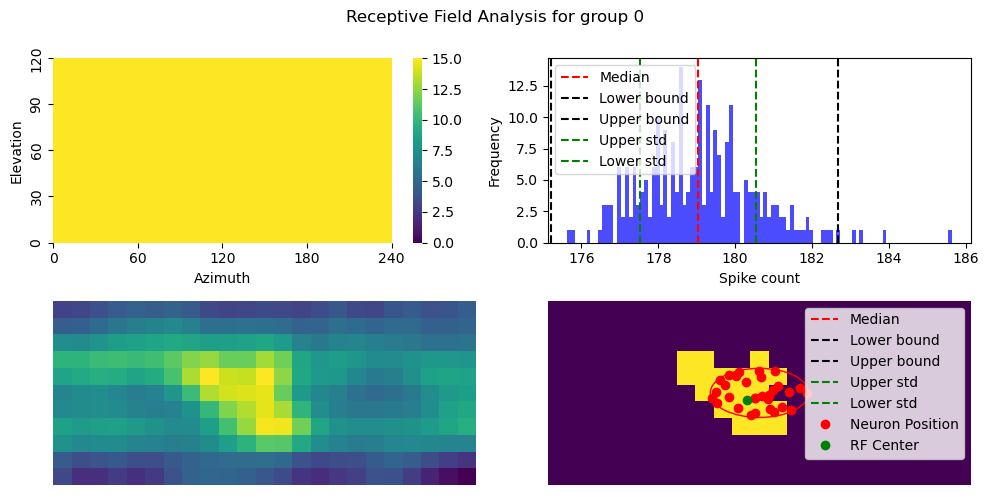

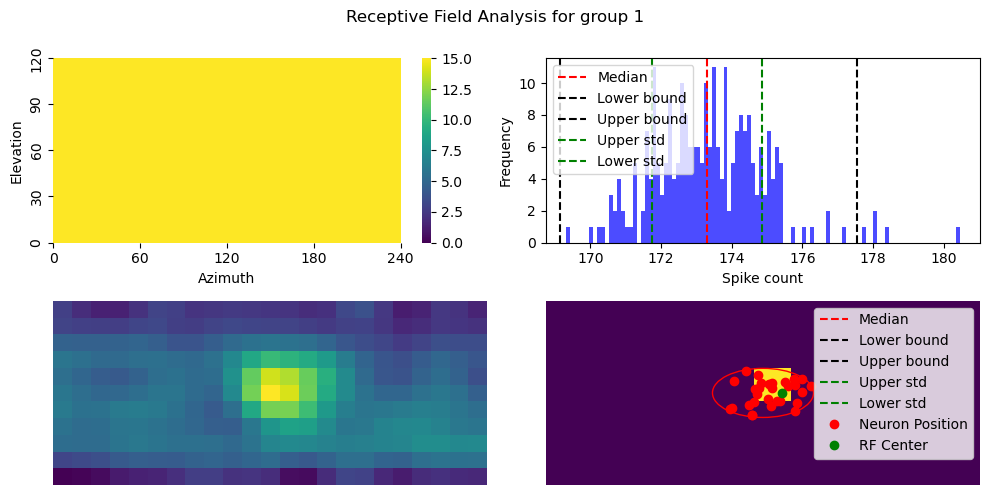

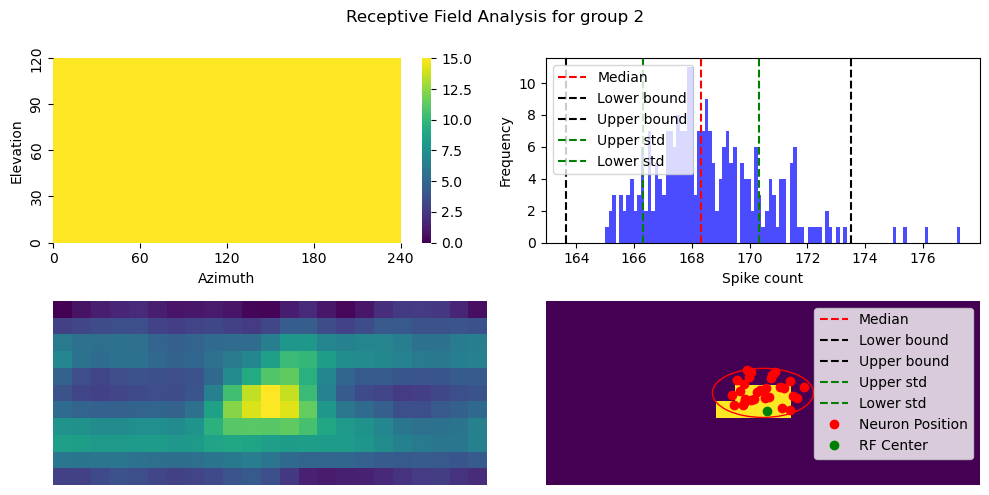

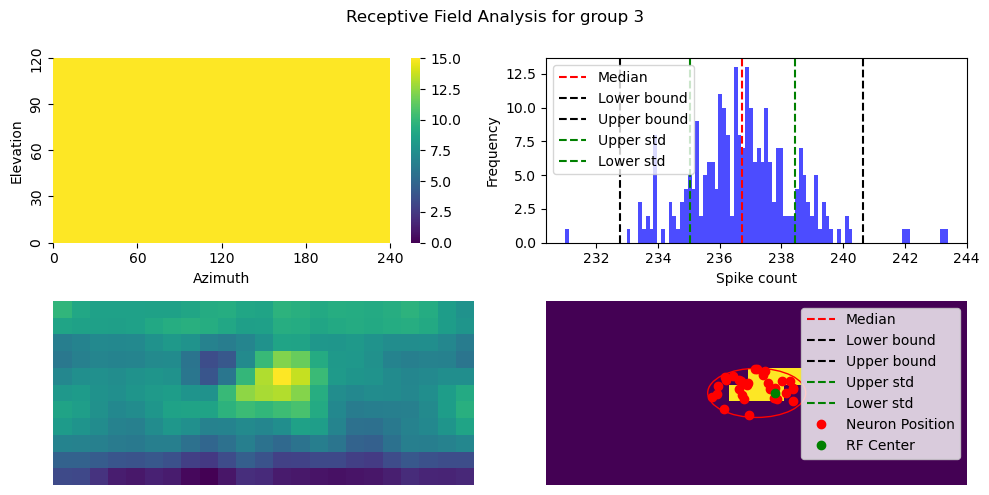

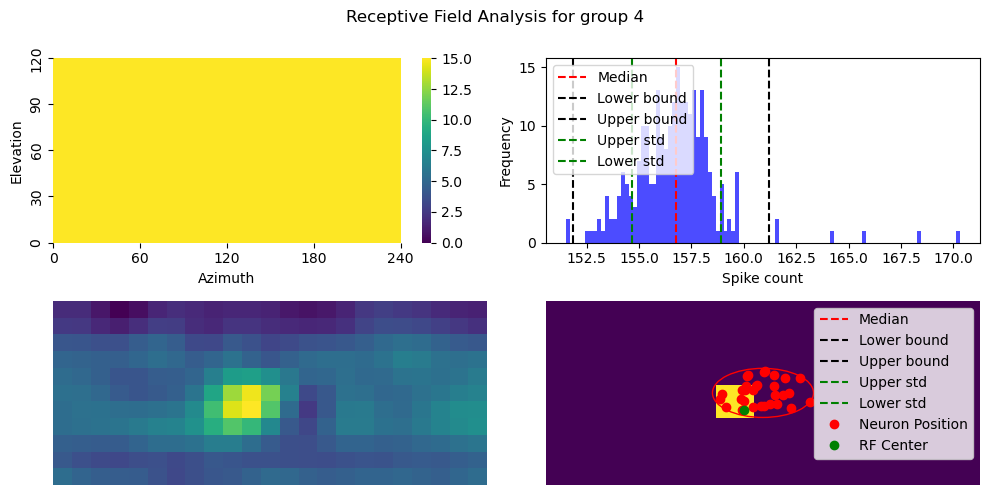

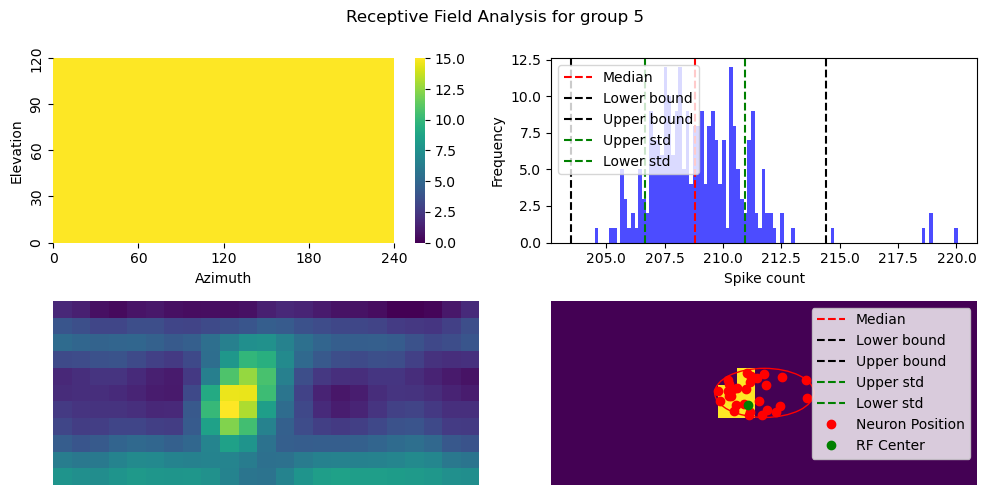

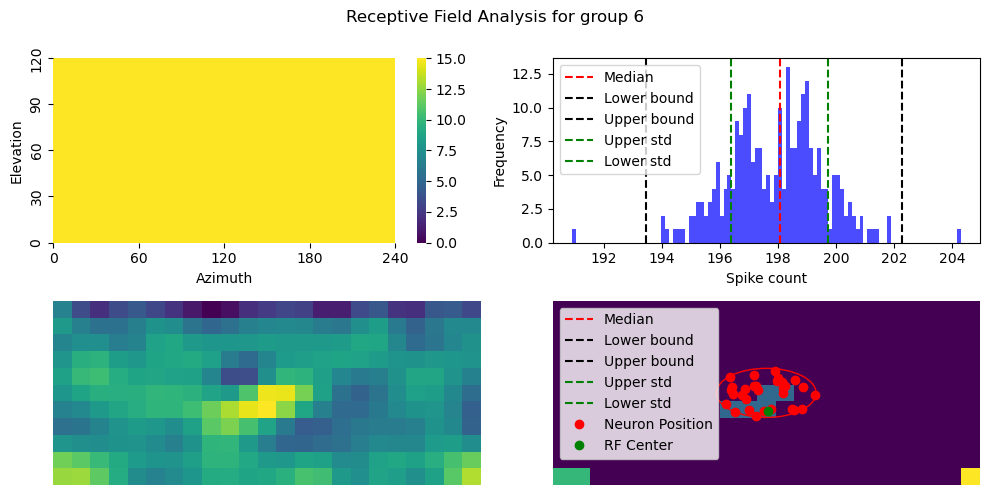

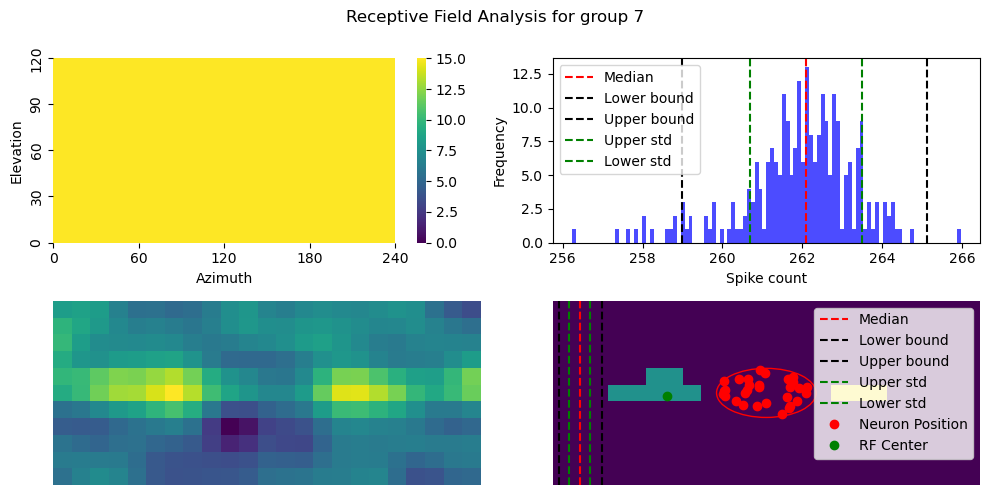

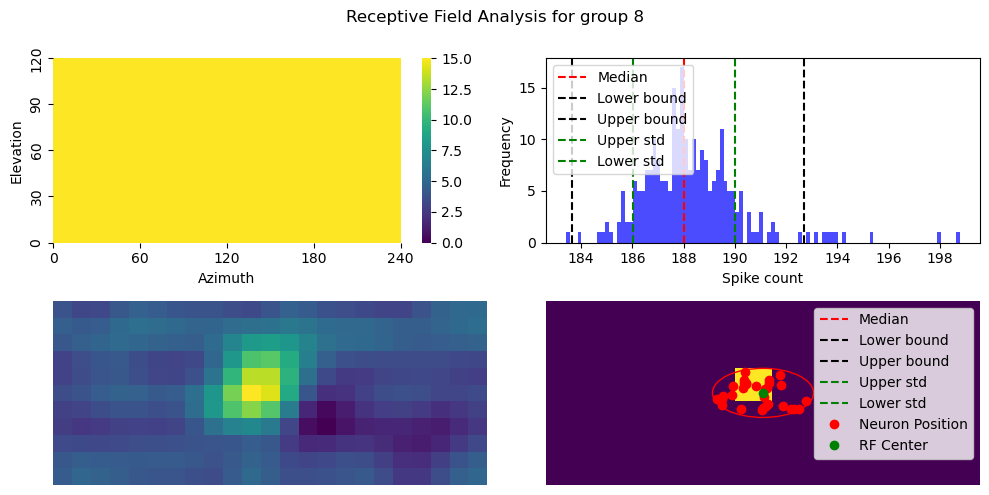

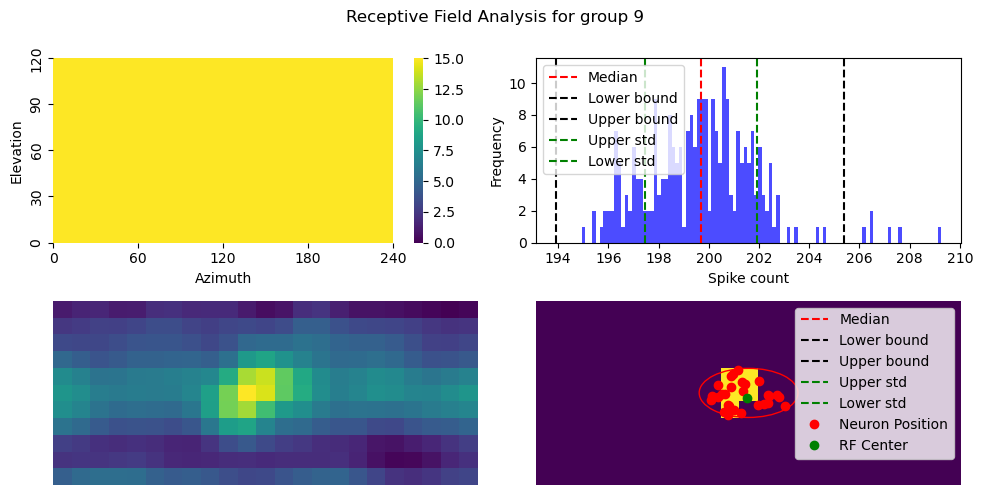

In [ ]:
### SELECT A GROUP OF NEURONS ###
for group_id in range(10):
    group_tf_ids = networks['v1'][f'readout_neuron_ids_{group_id}'][0]
    group_core_ids = v1_tf_id_core_id[group_tf_ids]
    # print('Neuron types:', np.array(v1_cell_types)[group_core_ids])
    group_pos = v1_visual_coordinates[group_core_ids]
    # get the average firing rate of the group of neurons
    expected_fr = np.mean(v1_fr[:,:,group_core_ids], axis=-1)
    total_spike_count = np.mean(v1_total_spikes[:,:, group_core_ids], axis=-1)

    if np.mean(expected_fr) < 0.1:
        print('Neuron has a low firing rate, select another neuron')
        # return np.nan for every feature in the df table
        # break

    # Apply the Gaussian filter to the total spike count
    rf_filt = scipy.ndimage.gaussian_filter(total_spike_count, 1)

    if is_rf_inverted(total_spike_count):
        # print('Inverted RF')
        rf_filt = invert_rf(rf_filt)

    # Apply a threshold to the filtered RF
    threshold_value = np.max(rf_filt) - np.std(rf_filt)
    rf_thresh = np.zeros(total_spike_count.shape, dtype="bool")
    rf_thresh[rf_filt > threshold_value] = True

    # Perform connected component analysis
    labels, num_features = ndi.label(rf_thresh)
    # Computes the maximum value of rf_filt for each labeled region 
    strongest_label = np.argmax(ndi.maximum(rf_filt, labels=labels, index=np.unique(labels)))
    largest_label = np.argmax(np.bincount(labels.flat)[1:]) + 1
    if largest_label != strongest_label:
        print('The largest label is not the strongest label')
        # check if both labels have the same area, then pick the strongest
        if np.sum(labels == largest_label) == np.sum(labels == strongest_label):
            print(' Both labels have the same area. Picking the strongest label.')
            # pick the strongest
            best_label = strongest_label
        else:
            # print('Both labels have different areas')
            # pick the largest
            best_label = largest_label
    else:
        best_label = largest_label

    unfiltered_labels = labels.copy()
    labels[labels != best_label] = 0
    labels[labels > 0] = 1

    center_y, center_x = ndi.center_of_mass(labels)
    # this center is located in the upper left corner of the pixel
    center_x = np.around(center_x, 4)
    center_y = np.around(center_y, 4)
    # THIS SHOULD BE CONVERTED TO VISUAL SPACE
    center_azimuth = convert_azimuth_to_degrees(center_x)
    center_elevation = convert_elevation_to_degrees(center_y, n_rows)

    pixels_area = float(np.sum(labels))
    # convert the area to visual space
    rf_area = convert_pixel_area_to_degrees(pixels_area)

    fig, axs = plt.subplots(2, 2, figsize=(10, 5))
    axs = axs.flatten()

    ### PLOT THE TOTAL SPIKE COUNT ###
    vmin = 0
    vmax = 15
    sns.heatmap(total_spike_count, cmap='viridis', cbar=True, ax=axs[0], vmin=vmin, vmax=vmax)
    # Define the azimuth and elevation coordinates
    azimuth_ticks = np.linspace(0, v1_fr.shape[1], 5)  # Adjust based on data shape
    azimuth_labels = np.linspace(0, 240, 5, dtype=int)
    elevation_ticks = np.linspace(v1_fr.shape[0], 0, 5)  # Adjust based on data shape
    elevation_labels = np.linspace(0, 120, 5, dtype=int)
    # Change the x and y labels and set ticks to match azimuth and elevation coordinates
    axs[0].set_xlabel('Azimuth')
    axs[0].set_ylabel('Elevation')
    axs[0].set_xticks(azimuth_ticks)
    axs[0].set_xticklabels(azimuth_labels)
    axs[0].set_yticks(elevation_ticks)
    axs[0].set_yticklabels(elevation_labels)
    # axs[0].axis('off')

    ### PLOT THE SPIKE COUNT DISTRIBUTION ###
    expected_value = np.median(total_spike_count)
    axs[1].hist(total_spike_count.flatten(), bins=100, color='b', alpha=0.7)
    axs[1].axvline(expected_value, color='r', linestyle='--', label='Median')
    q1 = np.percentile(total_spike_count, 25)  # First quartile (25th percentile)
    q3 = np.percentile(total_spike_count, 75)  # Third quartile (75th percentile)
    iqr = q3 - q1
    # Define thresholds
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    axs[1].axvline(lower_bound, color='k', linestyle='--', label='Lower bound')
    axs[1].axvline(upper_bound, color='k', linestyle='--', label='Upper bound')
    # plot also vlines for the std
    std = np.std(total_spike_count)
    axs[1].axvline(expected_value + std, color='g', linestyle='--', label='Upper std')
    axs[1].axvline(expected_value - std, color='g', linestyle='--', label='Lower std')
    # Add labels and legend
    axs[1].set_xlabel('Spike count')
    axs[1].set_ylabel('Frequency')
    axs[1].legend(loc='upper left')

    ### PLOT THE SMOOTHED FIRING RATE ###
    sns.heatmap(rf_filt, cmap='viridis', cbar=False, ax=axs[2])
    axs[2].axis('off')

    ### LABEL THE RECEPTIVE FIELD ###
    # sns.heatmap(labels, cmap='viridis', cbar=False, ax=axs[3])
    sns.heatmap(unfiltered_labels, cmap='viridis', cbar=False, ax=axs[3])
    # axs[3].plot(neuron_pos[0]*n_cols/col_size, neuron_pos[1]*n_rows/row_size, 'ro', label='Neuron Position')
    axs[3].plot(group_pos[:, 0]*n_cols/col_size, group_pos[:, 1]*n_rows/row_size, 'ro', label='Neuron Position')
    axs[3].plot(center_x+1, center_y+1, 'go', label='RF Center')
    # obtain the v1 projection ellipse
    x_axis =(max(v1_visual_coordinates[:, 0]) - min(v1_visual_coordinates[:, 0]))*n_cols/col_size
    y_axis = (max(v1_visual_coordinates[:, 1]) - min(v1_visual_coordinates[:, 1]))*n_rows/row_size
    center = (120*n_cols/col_size, 60*n_rows/row_size)
    # # obtain the neuron mapping position in the visual field
    # neuron_pos[0] = neuron_pos[0]*n_cols/col_size
    # neuron_pos[1] = neuron_pos[1]*n_rows/row_size
    ellipse = Ellipse(center, width=x_axis, height=y_axis, fill=False, edgecolor='r')
    axs[3].add_patch(ellipse)
    axs[3].legend()
    axs[3].axis('off')

    fig.suptitle('Receptive Field Analysis for group %s' % group_id)
    fig.tight_layout()

In [74]:
counter = 0
conflicting_neurons_ids = []
conflicting = np.zeros(51978, dtype=bool)
inverted_neurons_ids = []
conflicting_inverted_ids = np.zeros(51978, dtype=bool)

for neuron_id in range(51978):
    neuron_type = v1_cell_types[neuron_id]
    expected_fr = np.copy(v1_fr[:,:,neuron_id]) # 1
    total_spike_count = np.copy(v1_total_spikes[:,:,neuron_id]) # 1
    if np.mean(expected_fr) < 0.1:
        # print('Neuron has a low firing rate, select another neuron')
        # return np.nan for every feature in the df table
        # break
        continue
    else:        
        # Compute the total spike count in the receptive field
        rf_filt = scipy.ndimage.gaussian_filter(total_spike_count, 1)
        if is_rf_inverted_cluster_sum(total_spike_count) != is_rf_inverted(total_spike_count):
            conflicting_inverted_ids[neuron_id] = True

        if is_rf_inverted_cluster_sum(total_spike_count):
            # print('Inverted RF')
            rf_filt = invert_rf(rf_filt)
            inverted_neurons_ids.append(neuron_id)

        threshold_value = np.max(rf_filt) - np.std(rf_filt)
        rf_thresh = np.zeros(total_spike_count.shape, dtype="bool")
        rf_thresh[rf_filt > threshold_value] = True
        labels, num_features = ndi.label(rf_thresh)

        expected_value = np.mean(total_spike_count)
        # compute residuals
        original_residuals = (total_spike_count - expected_value)**2 / (expected_value + 1e-6)
        # compute the chi2 value for each cluster as the sum over cluster pixels and choose the one with the largest value
        chi2_values = np.zeros(num_features)
        for i in range(1, num_features + 1):
            cluster_pixels = original_residuals[labels == i]
            chi2_values[i - 1] = np.sum(cluster_pixels)
        
        if len(chi2_values) > 0:
            best_cluster_index = np.argmax(chi2_values) + 1
        else:
            best_cluster_index = 0

        # Computes the maximum value of rf_filt for each labeled region 
        strongest_label = np.argmax(ndi.maximum(rf_filt, labels=labels, index=np.unique(labels)))

        if strongest_label != best_cluster_index:
            # print('Conflicting labels for neuron %d' % neuron_id)
            # print(' Strongest label:', strongest_label)
            # print(' Best label:', best_cluster_index)
            conflicting_neurons_ids.append(neuron_id)
            conflicting[neuron_id] = True

In [77]:
len(conflicting_inverted_ids), conflicting_inverted_ids.sum()

(51978, 1587)

In [78]:
len(conflicting_neurons_ids), len(inverted_neurons_ids), conflicting.sum()

(3744, 6274, 3744)

Neuron 14 of type L5 Exc has an inverted receptive field with 9 clusters
Neuron 16 of type L5 Exc has an inverted receptive field with 4 clusters
Neuron 19 of type L5 Exc has an inverted receptive field with 4 clusters


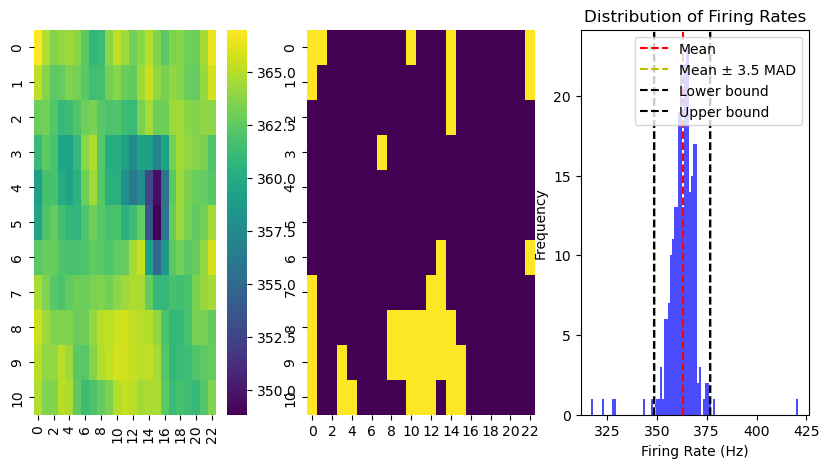

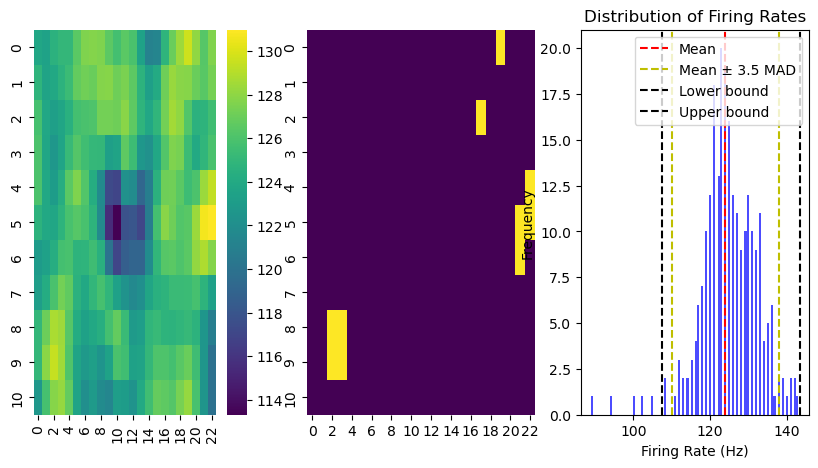

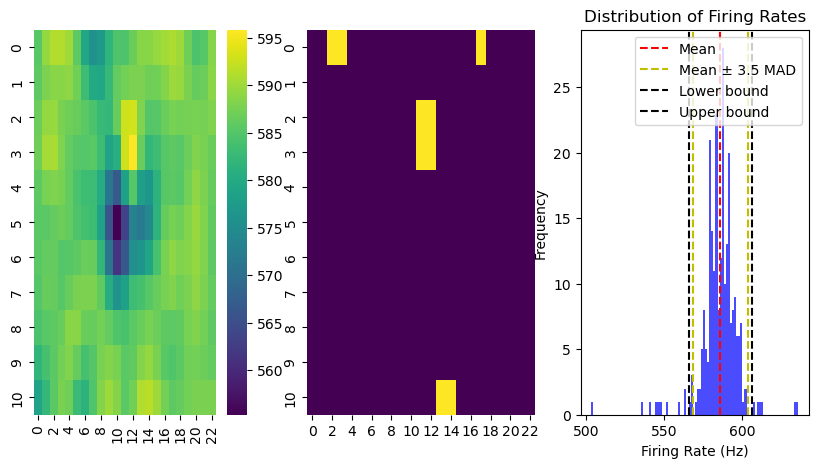

In [ ]:
counter = 0
inverted_siegle = []
inverted_sofia = []
inverted_javi = []

for neuron_id in range(51978):
    neuron_type = v1_cell_types[neuron_id]
    expected_fr = np.copy(v1_fr[:,:,neuron_id]) # 1
    total_spike_count = np.copy(v1_total_spikes[:,:,neuron_id]) # 1
    if np.mean(expected_fr) < 0.1:
        print('Neuron has a low firing rate, select another neuron')
        # return np.nan for every feature in the df table
        break
    # Compute the total spike count in the receptive field
    rf_filt = scipy.ndimage.gaussian_filter(total_spike_count, 1)
    threshold_value = np.max(rf_filt) - np.std(rf_filt)
    rf_thresh = np.zeros(total_spike_count.shape, dtype="bool")
    rf_thresh[rf_filt > threshold_value] = True
    labels, num_features = ndi.label(rf_thresh)

    # if is_rf_inverted(total_spike_count) and len(np.unique(labels)) > 1:
    if not is_rf_inverted_siegle(rf_thresh) and is_rf_inverted_sofia(total_spike_count, expected_fr):

        # inverted_javi.append(neuron_id)

        print(f'Neuron {neuron_id} of type {neuron_type} has an inverted receptive field with {num_features} clusters')
        fig, axs = plt.subplots(1, 3, figsize=(10, 5))
        sns.heatmap(rf_filt, cmap='viridis', cbar=True, ax=axs[0])
        sns.heatmap(rf_thresh, cmap='viridis', cbar=False, ax=axs[1])
        ### PLOT THE FR DISTRIBUTION ###
        expected_value = np.median(total_spike_count)
        std = np.std(total_spike_count)
        mad = np.median(np.abs(total_spike_count - expected_value))
        axs[2].hist(total_spike_count.flatten(), bins=100, color='b', alpha=0.7)
        # Plot mean and deviation lines
        axs[2].axvline(expected_value, color='r', linestyle='--', label='Mean')
        # axs[2].axvline(expected_value + 2*std, color='g', linestyle='--', label='Mean ± 2 Std Dev')
        # axs[2].axvline(expected_value - 2*std, color='g', linestyle='--')
        axs[2].axvline(expected_value + mad * 3.5, color='y', linestyle='--', label='Mean ± 3.5 MAD')
        axs[2].axvline(expected_value - mad * 3.5, color='y', linestyle='--')
        q1 = np.percentile(total_spike_count, 25)  # First quartile (25th percentile)
        q3 = np.percentile(total_spike_count, 75)  # Third quartile (75th percentile)
        iqr = q3 - q1
        # Define thresholds
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        axs[2].axvline(lower_bound, color='k', linestyle='--', label='Lower bound')
        axs[2].axvline(upper_bound, color='k', linestyle='--', label='Upper bound')
        # Add labels and legend
        axs[2].set_xlabel('Firing Rate (Hz)')
        axs[2].set_ylabel('Frequency')
        axs[2].set_title('Distribution of Firing Rates')
        axs[2].legend(loc='upper right')

        # stop the loop 
        counter += 1
        # break
    if counter == 3:
        break

    # if is_rf_inverted_sofia(total_spike_count, expected_fr) and len(np.unique(labels)) > 1:
    #     inverted_sofia.append(neuron_id)

    # if is_rf_inverted_javi(total_spike_count) and len(np.unique(labels)) > 1:
    #     inverted_javi.append(neuron_id)

# count the number of neurons that are in both lists, just in siegle aand just in sofia
# common_neurons = list(set(inverted_sofia) & set(inverted_javi))
# len(inverted_sofia), len(inverted_javi), len(common_neurons)

In [195]:
q1 = np.percentile(total_spike_count, 25)  # First quartile (25th percentile)
q3 = np.percentile(total_spike_count, 75)  # Third quartile (75th percentile)
iqr = q3 - q1
# Define thresholds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
# Identify outliers
high_outliers = total_spike_count > upper_bound
low_outliers = total_spike_count < lower_bound
# print the outliers values
print(lower_bound, upper_bound)
print('High outliers:', total_spike_count[high_outliers])
print('Low outliers:', total_spike_count[low_outliers])

# Compute mean and standard deviation
mean_firing_rate = np.mean(total_spike_count)
std_firing_rate = np.std(total_spike_count)
# Compute z-scores
z_scores = (total_spike_count - mean_firing_rate) / std_firing_rate
# Define thresholds for z-scores
high_outliers_z = z_scores > 2  # High-firing outliers
low_outliers_z = z_scores < -2 # Low-firing outliers
lower_bound = mean_firing_rate - 2 * std_firing_rate
upper_bound = mean_firing_rate + 2 * std_firing_rate
print(lower_bound, upper_bound)
print('High outliers:', total_spike_count[high_outliers])
print('Low outliers:', total_spike_count[low_outliers])

# Recalculate the expected value
expected_value = np.median(total_spike_count)
# Recalculate the std and mad
std = np.std(total_spike_count)
mad = np.median(np.abs(total_spike_count - expected_value))

lower_bound = expected_value - 3.5 * mad
upper_bound = expected_value + 3.5 * mad
print(lower_bound, upper_bound)

above_std = total_spike_count[total_spike_count > expected_value + mad*3.5]
below_std = total_spike_count[total_spike_count < expected_value - mad*3.5]
# outliers = np.concatenate((above_std, below_std))
print('High outliers:', above_std)
print('Low outliers:', below_std)

348.5 376.5
High outliers: [377. 379. 421.]
Low outliers: [317. 343. 328. 323. 329. 348.]


# RF all neurons

In [62]:
def get_rf_stats(spike_counts, firing_rates, neuron_id):
    average_firing_rate = firing_rates[:,:,neuron_id] 
    total_spike_count = spike_counts[:,:,neuron_id] 
    
    if np.mean(average_firing_rate) < 0.1:
        # print(f'Neuron {neuron_id} has a low firing rate, select another neuron')
        # return np.nan for every feature in the df table
        return np.nan, np.nan, np.nan, np.nan#, np.nan

    # Apply the Gaussian filter to the total spike count
    rf_filt = scipy.ndimage.gaussian_filter(total_spike_count, 1)

    if is_rf_inverted_cluster_sum(total_spike_count):
        inverse_rf = True
        rf_filt = invert_rf(rf_filt)
    else:
        inverse_rf = False

    # Apply a threshold to the filtered RF
    threshold_value = np.max(rf_filt) - np.std(rf_filt)
    rf_thresh = np.zeros(total_spike_count.shape, dtype="bool")
    rf_thresh[rf_filt > threshold_value] = True

    # Perform connected component analysis
    labels, num_features = ndi.label(rf_thresh)

    expected_value = np.mean(total_spike_count)
    # compute residuals
    original_residuals = (total_spike_count - expected_value)**2 / (expected_value + 1e-6)
    # compute the chi2 value for each cluster as the sum over cluster pixels and choose the one with the largest value
    chi2_values = np.zeros(num_features)
    for i in range(1, num_features + 1):
        cluster_pixels = original_residuals[labels == i]
        chi2_values[i - 1] = np.sum(cluster_pixels)
    best_cluster_index = np.argmax(chi2_values) + 1

    if len(chi2_values) > 0:
        best_cluster_index = np.argmax(chi2_values) + 1
    else:
        best_cluster_index = 0
    
    # Computes the maximum value of rf_filt for each labeled region 
    strongest_label = np.argmax(ndi.maximum(rf_filt, labels=labels, index=np.unique(labels)))
    largest_label = np.argmax(np.bincount(labels.flat)[1:]) + 1

    best_label = best_cluster_index
    labels[labels != best_label] = 0
    labels[labels > 0] = 1

    center_y, center_x = ndi.center_of_mass(labels)
    # this center is located in the upper left corner of the pixel
    center_x = np.around(center_x, 4)
    center_y = np.around(center_y, 4)
    # THIS SHOULD BE CONVERTED TO VISUAL SPACE
    center_azimuth = convert_azimuth_to_degrees(center_x)
    center_elevation = convert_elevation_to_degrees(center_y, n_rows)

    pixels_area = float(np.sum(labels))
    # convert the area to visual space
    rf_area = convert_pixel_area_to_degrees(pixels_area)
    
    if rf_area > 2500 or rf_area <= 0:
        return np.nan, np.nan, np.nan, np.nan#, np.nan

    return center_azimuth, center_elevation, rf_area, inverse_rf#, problematic_assignment

In [63]:
# V1
rf_areas_v1 = np.zeros((n_core_neurons_v1))
center_of_mass_v1 = np.zeros((n_core_neurons_v1, 2))
inverse_rf_v1 = np.zeros((n_core_neurons_v1))
# problematic_assignments_v1 = np.zeros((n_core_neurons_v1), dtype=bool)

for neuron_id in tqdm(range(n_core_neurons_v1)):
    center_azimuth, center_elevation, rf_area, inverse_rf = get_rf_stats(v1_total_spikes, v1_fr, neuron_id)
    rf_areas_v1[neuron_id] = rf_area
    center_of_mass_v1[neuron_id, :] = center_azimuth, center_elevation
    inverse_rf_v1[neuron_id] = inverse_rf
    # problematic_assignments_v1[neuron_id] = problematic_assignment

# LM
rf_areas_lm = np.zeros((n_core_neurons_lm))
center_of_mass_lm = np.zeros((n_core_neurons_lm, 2))
inverse_rf_lm = np.zeros((n_core_neurons_lm))

for neuron_id in tqdm(range(n_core_neurons_lm)):
    center_azimuth, center_elevation, rf_area, inverse_rf = get_rf_stats(lm_total_spikes, lm_fr, neuron_id)
    rf_areas_lm[neuron_id] = rf_area
    center_of_mass_lm[neuron_id, :] = center_azimuth, center_elevation
    inverse_rf_lm[neuron_id] = inverse_rf

100%|██████████| 7414/7414 [00:00<00:00, 9001.48it/s] 


In [64]:
np.sum(inverse_rf_v1==1), np.sum(inverse_rf_v1==0), np.sum(np.isnan(inverse_rf_v1))

(5869, 39087, 7022)

In [66]:
np.sum(rf_areas_v1 > 2500), np.sum(rf_areas_v1 <= 0), #np.sum(problematic_assignments_v1)

(0, 0)

### Add data to the csv file

In [16]:
# Load the csv with data
df_v1 = pd.read_csv("/home/jgalvan/Desktop/Neurocoding/LM_V1_Billeh_model/Benchmark_models/v1_100000_lm_30000/v1_features_df.csv", delimiter=' ')
df_lm = pd.read_csv("/home/jgalvan/Desktop/Neurocoding/LM_V1_Billeh_model/Benchmark_models/v1_100000_lm_30000/lm_features_df.csv", delimiter=' ')

# add a column to df_v1 with the RF areas
df_v1['RF_area'] = rf_areas_v1
df_lm['RF_area'] = rf_areas_lm

# add center of mass position
df_v1['RF_center'] = list(center_of_mass_v1)
df_lm['RF_center'] = list(center_of_mass_lm)

# add the visual coordinates of the neurons
df_v1['Visual_coordinates'] = list(v1_visual_coordinates)
df_lm['Visual_coordinates'] = list(lm_visual_coordinates)

# add inverse RF or not as True or False depending if the index is in the inverse_indices list
df_v1['Inverse_RF'] = inverse_rf_v1
df_lm['Inverse_RF'] = inverse_rf_lm

In [17]:
np.nanmin(center_of_mass_v1, axis=0), np.nanmax(center_of_mass_v1, axis=0)

(array([10., 10.]), array([230., 110.]))

In [18]:
np.nanmin(lm_visual_coordinates, axis=0), np.nanmax(lm_visual_coordinates, axis=0)

(array([91.91092 , 43.910927], dtype=float32),
 array([148.19229,  76.06775], dtype=float32))

Text(0.5, 0.98, 'V1 neurons RF center and visual coordinates')

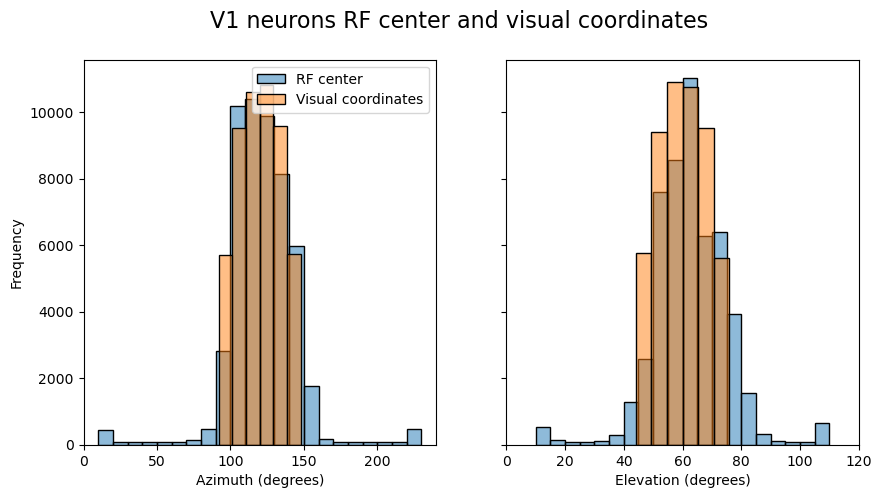

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# plot the displacement in azimuth in the receptive field center with respect to the visual coordinates
sns.histplot(np.array(center_of_mass_v1)[:, 0], binwidth=10, ax=axs[0], alpha=0.5, label='RF center')
sns.histplot(np.array(v1_visual_coordinates)[:, 0], binwidth=10, ax=axs[0], alpha=0.5, label='Visual coordinates')
axs[0].set_xlabel('Azimuth (degrees)')
axs[0].set_ylabel('Frequency')
axs[0].set_xlim(0, 240)
axs[0].legend()

# plot the displacement in elevation in the receptive field center with respect to the visual coordinates
sns.histplot(np.array(center_of_mass_v1)[:, 1], binwidth=5, ax=axs[1], alpha=0.5)
sns.histplot(np.array(v1_visual_coordinates[:, 1]), binwidth=5, ax=axs[1], alpha=0.5)
axs[1].set_xlabel('Elevation (degrees)')
axs[1].set_ylabel('Frequency')
axs[1].set_xlim(0, 120)

# set title
fig.suptitle('V1 neurons RF center and visual coordinates', fontsize=16)

Text(0.5, 0.98, 'LM neurons RF center and visual coordinates')

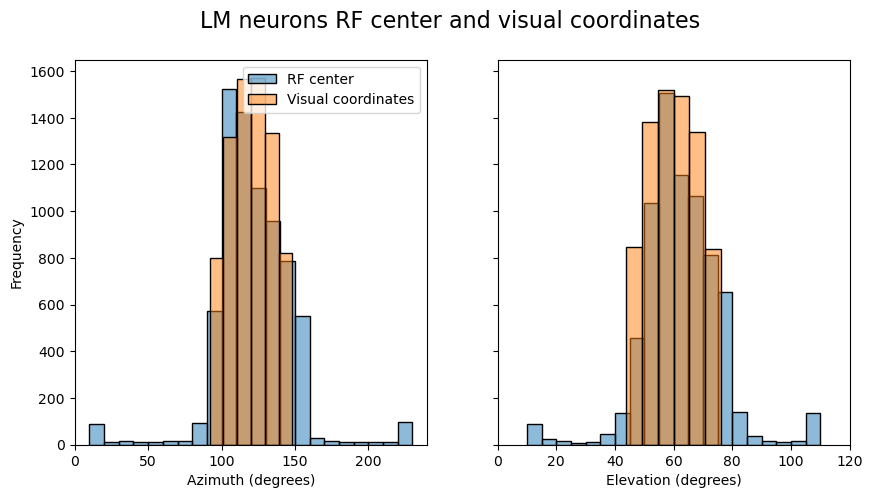

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# plot the displacement in azimuth in the receptive field center with respect to the visual coordinates
sns.histplot(np.array(center_of_mass_lm)[:, 0], binwidth=10, ax=axs[0], alpha=0.5, label='RF center')
sns.histplot(np.array(lm_visual_coordinates)[:, 0], binwidth=10, ax=axs[0], alpha=0.5, label='Visual coordinates')
axs[0].set_xlabel('Azimuth (degrees)')
axs[0].set_ylabel('Frequency')
axs[0].set_xlim(0, 240)
axs[0].legend()

# plot the displacement in elevation in the receptive field center with respect to the visual coordinates
sns.histplot(np.array(center_of_mass_lm)[:, 1], binwidth=5, ax=axs[1], alpha=0.5)
sns.histplot(np.array(lm_visual_coordinates[:, 1]), binwidth=5, ax=axs[1], alpha=0.5)
axs[1].set_xlabel('Elevation (degrees)')
axs[1].set_ylabel('Frequency')
axs[1].set_xlim(0, 120)

# set title
fig.suptitle('LM neurons RF center and visual coordinates', fontsize=16)

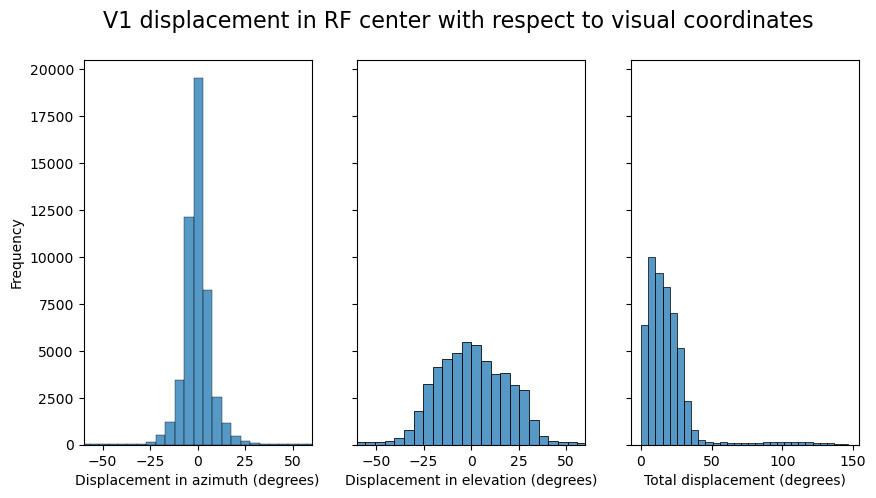

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5), sharey=True)

# plot the displacement in azimuth in the receptive field center with respect to the visual coordinates
displacement_azimuth = np.array(center_of_mass_v1)[:, 0] - np.array(v1_visual_coordinates)[:, 0]
sns.histplot(displacement_azimuth, binwidth=5, ax=axs[0])
axs[0].set_xlabel('Displacement in azimuth (degrees)')
axs[0].set_ylabel('Frequency')
axs[0].set_xlim(-60, 60)

# plot the displacement in elevation in the receptive field center with respect to the visual coordinates
displacement_elevation = np.array(center_of_mass_v1)[:, 1] - np.array(v1_visual_coordinates)[:, 1]
sns.histplot(displacement_elevation, binwidth=5, ax=axs[1])
axs[1].set_xlabel('Displacement in elevation (degrees)')
axs[1].set_ylabel('Frequency')
axs[1].set_xlim(-60, 60)

# plot the total distance between the receptive field center and the visual coordinates
displacement = np.sqrt(displacement_azimuth**2 + displacement_elevation**2)
sns.histplot(displacement, binwidth=5, ax=axs[2])
axs[2].set_xlabel('Total displacement (degrees)')
axs[2].set_ylabel('Frequency')

fig.suptitle('V1 displacement in RF center with respect to visual coordinates', fontsize=16)
plt.show()

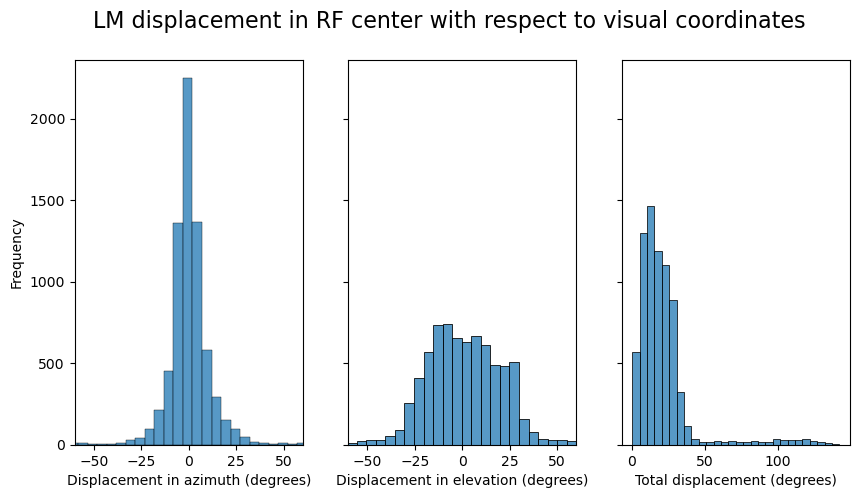

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5), sharey=True)

# plot the displacement in azimuth in the receptive field center with respect to the visual coordinates
displacement_azimuth = np.array(center_of_mass_lm)[:, 0] - np.array(lm_visual_coordinates)[:, 0]
sns.histplot(displacement_azimuth, binwidth=5, ax=axs[0])
axs[0].set_xlabel('Displacement in azimuth (degrees)')
axs[0].set_ylabel('Frequency')
axs[0].set_xlim(-60, 60)

# plot the displacement in elevation in the receptive field center with respect to the visual coordinates
displacement_elevation = np.array(center_of_mass_lm)[:, 1] - np.array(lm_visual_coordinates)[:, 1]
sns.histplot(displacement_elevation, binwidth=5, ax=axs[1])
axs[1].set_xlabel('Displacement in elevation (degrees)')
axs[1].set_ylabel('Frequency')
axs[1].set_xlim(-60, 60)

# plot the total distance between the receptive field center and the visual coordinates
displacement = np.sqrt(displacement_azimuth**2 + displacement_elevation**2)
sns.histplot(displacement, binwidth=5, ax=axs[2])
axs[2].set_xlabel('Total displacement (degrees)')
axs[2].set_ylabel('Frequency')

fig.suptitle('LM displacement in RF center with respect to visual coordinates', fontsize=16)
plt.show()

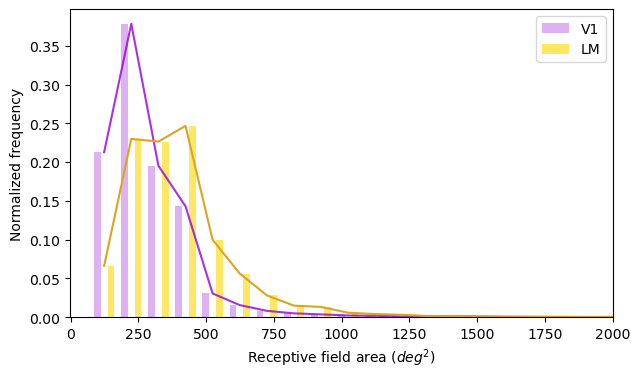

V1 median: 200.0
LM median: 300.0

V1 mean: 260.3358223391496
LM mean: 369.418794133623


In [23]:
# Define bin edges and centers
bin_edges = np.arange(-1, 100*100, 50)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# Calculate histograms
hist_v1, _ = np.histogram(rf_areas_v1, bins=bin_edges)
hist_lm, _ = np.histogram(rf_areas_lm, bins=bin_edges)
# hist_v1_dis, _ = np.histogram(rf_areas_v1_dis, bins=bin_edges)
# Normalize histograms
hist_v1 = hist_v1 / np.sum(hist_v1)
hist_lm = hist_lm / np.sum(hist_lm)
# hist_v1_dis = hist_v1_dis / np.sum(hist_v1_dis)
# Width of each bar
width = (bin_edges[1] - bin_edges[0]) / 2
# Create bar plots
plt.figure(figsize = (7,4))
plt.bar(bin_centers - width, hist_v1, width=width, color='darkviolet', label='V1', alpha=0.3)
plt.bar(bin_centers + width, hist_lm, width=width, color='gold', label='LM', alpha=0.6)
# plt.bar(bin_centers, hist_v1_dis, width=width, color='indigo', label='V1 disconnected', alpha=0.6)
# Create line plots for non-zero values
plt.plot(bin_centers[hist_v1 > 0], hist_v1[hist_v1 > 0], color='darkviolet', alpha = 0.8)
plt.plot(bin_centers[hist_lm > 0], hist_lm[hist_lm > 0], color='goldenrod')
# plt.plot(bin_centers[hist_v1_dis > 0], hist_v1_dis[hist_v1_dis > 0], color='indigo')
plt.xlabel(r'Receptive field area ($deg^2$)')
plt.ylabel('Normalized frequency')
plt.xlim(-1, 2000)
plt.legend()
plt.show()
# print the medians
print('V1 median:', np.nanmedian(rf_areas_v1))
print('LM median:', np.nanmedian(rf_areas_lm))
# print('V1 disconnected median:', np.nanmedian(rf_areas_v1_dis))
# print the means
print()
print('V1 mean:', np.nanmean(rf_areas_v1))
print('LM mean:', np.nanmean(rf_areas_lm))
# print('V1 disconnected mean:', np.nanmean(rf_areas_v1_dis))

### Old code

In [21]:
# V1
rf_areas_v1 = np.zeros((n_core_neurons_v1))
inverse_indices_v1 = []
center_of_mass_v1 = np.zeros((n_core_neurons_v1, 2))

for neuron in tqdm(range(n_core_neurons_v1)):
    # select the given neuron
    v1_neuron = np.copy(v1_fr[:,:,neuron])
    expected_value = np.median(v1_neuron)
    # set 0.0 values to percentile median
    v1_neuron[np.round(v1_neuron) == 0.0] = expected_value
    mad = np.median(np.abs(v1_neuron - expected_value))
    # obtain list of positions above and below the std
    above_std = v1_neuron[v1_neuron > expected_value + mad*3.5]
    below_std = v1_neuron[v1_neuron < expected_value - mad*3.5]
    above_std_map_binary = np.zeros(v1_neuron.shape)
    below_std_map_binary = np.zeros(v1_neuron.shape)
    # merge
    outliers = np.concatenate((above_std, below_std))
    if len(above_std) > 0:
        for i in range(len(above_std)):
            idx = np.where(v1_neuron == above_std[i])
            above_std_map_binary[idx] = 1
        # labelling connected components
        above_std_map = skimage.measure.label(above_std_map_binary)
        # get the largest connected component of each map
        above_std_map = (above_std_map == np.argmax(np.bincount(above_std_map.flat)[1:]) + 1)
        # get the list of positions
        above_std_positions_largest = np.where(above_std_map == 1)
    else:
        above_std_positions_largest = [[]]  

    if len(below_std) > 0:
        for i in range(len(below_std)):
            idx = np.where(v1_neuron == below_std[i])
            below_std_map_binary[idx] = 1
        below_std_map = skimage.measure.label(below_std_map_binary)
        below_std_map = (below_std_map == np.argmax(np.bincount(below_std_map.flat)[1:]) + 1)
        below_std_positions_largest = np.where(below_std_map == 1)
    else:
        below_std_positions_largest = [[]]

    if len(below_std_positions_largest[0]) > len(above_std_positions_largest[0]):
        inverse = True
    else:
        inverse = False

    if inverse:
        inverse_indices_v1.append(neuron)
        # obtain lists of the positions of all the connected components
        connected_components = label(below_std_map_binary)
        # Identify the largest connected component
        largest_cc_label = max(regionprops(connected_components), key=lambda r: r.area).label
        # Create a mask for the largest connected component and set it to 0
        below_std_map_binary[connected_components == largest_cc_label] = 0
        mask = (below_std_map_binary == 1)
        outlier_values = v1_neuron[mask]
        if len(outlier_values) > 0:
            threshold = np.max(outlier_values)
        else:
            threshold = 0
        # set values below or equal to threshold to the median
        # v1_neuron[v1_neuron <= threshold] = expected_value
        smooth_rf = scipy.ndimage.gaussian_filter(v1_neuron, sigma=1)
        v1_neuron_smooth = np.max(smooth_rf) - smooth_rf
    else:
        connected_components = label(below_std_map_binary)
        mask = (below_std_map_binary == 1)
        outlier_values = v1_neuron[mask]
        if len(outlier_values)>0:
            threshold = np.max(outlier_values)
        else:
            threshold = 0
        # set values below or equal to threshold to the median
        # v1_neuron[v1_neuron <= threshold] = expected_value
        v1_neuron_smooth = scipy.ndimage.gaussian_filter(v1_neuron, sigma=1)
        
    # now apply the threshold at max(RF) – std(RF)
    threshold = np.max(v1_neuron_smooth) - np.std(v1_neuron_smooth)
    v1_neuron_thresholded = np.zeros(v1_neuron_smooth.shape)
    v1_neuron_thresholded[v1_neuron_smooth > threshold] = 1
    # compute the area of the thresholded RF
    # select the largest connected component
    neuron_thresholded = skimage.measure.label(v1_neuron_thresholded)
    try:
        v1_neuron_thresholded = (neuron_thresholded == np.argmax(np.bincount(neuron_thresholded.flat)[1:]) + 1)
    except:
        v1_neuron_thresholded = np.zeros(v1_neuron_smooth.shape)

    # comptue the center of mass
    center_of_mass_v1[neuron] = np.array([np.mean(np.where(v1_neuron_thresholded)[0]), np.mean(np.where(v1_neuron_thresholded)[1])])
    # sum 0.5 to each component of the center of mass
    center_of_mass_v1[neuron] = (center_of_mass_v1[neuron][0]+0.5, center_of_mass_v1[neuron][1]+0.5)
    rf_areas_v1[neuron] = np.sum(v1_neuron_thresholded)*100
    if rf_areas_v1[neuron] > 2500 or rf_areas_v1[neuron] <= 0:
        # set to nan
        rf_areas_v1[neuron] = np.nan




# LM
rf_areas_lm = np.zeros((n_core_neurons_lm))
inverse_indices_lm = []
center_of_mass_lm = np.zeros((n_core_neurons_lm, 2))

for neuron in tqdm(range(n_core_neurons_lm)):
    # select the given neuron
    lm_neuron = np.copy(lm_fr[:,:,neuron])

    expected_value = np.median(lm_neuron)
    # set 0.0 values to percentile median
    lm_neuron[np.round(lm_neuron) == 0.0] = expected_value

    mad = np.median(np.abs(lm_neuron - expected_value))

    # obtain list of positions above and below the std
    above_std = lm_neuron[lm_neuron > expected_value + mad*3.5]
    below_std = lm_neuron[lm_neuron < expected_value - mad*3.5]

    above_std_map_binary = np.zeros(lm_neuron.shape)
    below_std_map_binary = np.zeros(lm_neuron.shape)
    # merge
    outliers = np.concatenate((above_std, below_std))

    if len(above_std) > 0:
        for i in range(len(above_std)):
            idx = np.where(lm_neuron == above_std[i])
            above_std_map_binary[idx] = 1

        # labelling connected components
        above_std_map = skimage.measure.label(above_std_map_binary)
        # get the largest connected component of each map
        above_std_map = (above_std_map == np.argmax(np.bincount(above_std_map.flat)[1:]) + 1)
        # get the list of positions
        above_std_positions_largest = np.where(above_std_map == 1)

    else:
        above_std_positions_largest = [[]]  

    if len(below_std) > 0:
        for i in range(len(below_std)):
            idx = np.where(lm_neuron == below_std[i])
            below_std_map_binary[idx] = 1

        below_std_map = skimage.measure.label(below_std_map_binary)
        below_std_map = (below_std_map == np.argmax(np.bincount(below_std_map.flat)[1:]) + 1)
        below_std_positions_largest = np.where(below_std_map == 1)

    else:
        below_std_positions_largest = [[]]

    if len(below_std_positions_largest[0]) > len(above_std_positions_largest[0]):
        inverse = True
    else:
        inverse = False

    if inverse:
        inverse_indices_lm.append(neuron)
        # obtain lists of the positions of all the connected components
        connected_components = label(below_std_map_binary)

        # Identify the largest connected component
        largest_cc_label = max(regionprops(connected_components), key=lambda r: r.area).label

        # Create a mask for the largest connected component and set it to 0
        below_std_map_binary[connected_components == largest_cc_label] = 0

        mask = (below_std_map_binary == 1)
        outlier_values = lm_neuron[mask]

        if len(outlier_values) > 0:
            threshold = np.max(outlier_values)
        else:
            threshold = 0

        # set values below or equal to threshold to the median
        # lm_neuron[lm_neuron <= threshold] = expected_value

        smooth_rf = scipy.ndimage.gaussian_filter(lm_neuron, sigma=1)

        lm_neuron_smooth = np.max(smooth_rf) - smooth_rf

    else:
        connected_components = label(below_std_map_binary)

        mask = (below_std_map_binary == 1)
        outlier_values = lm_neuron[mask]

        if len(outlier_values)>0:
            threshold = np.max(outlier_values)
        else:
            threshold = 0

        # set values below or equal to threshold to the median
        # lm_neuron[lm_neuron <= threshold] = expected_value

        lm_neuron_smooth = scipy.ndimage.gaussian_filter(lm_neuron, sigma=1)

    # now apply the threshold at max(RF) – std(RF)
    threshold = np.max(lm_neuron_smooth) - np.std(lm_neuron_smooth)
    lm_neuron_thresholded = np.zeros(lm_neuron_smooth.shape)
    lm_neuron_thresholded[lm_neuron_smooth > threshold] = 1

    # compute the area of the thresholded RF
    # select the largest connected component
    neuron_thresholded = skimage.measure.label(lm_neuron_thresholded)
    try:
        lm_neuron_thresholded = (neuron_thresholded == np.argmax(np.bincount(neuron_thresholded.flat)[1:]) + 1)
    except:
        lm_neuron_thresholded = np.zeros(lm_neuron_smooth.shape)

    # comptue the center of mass
    center_of_mass_lm[neuron] = np.array([np.mean(np.where(lm_neuron_thresholded)[0]), np.mean(np.where(lm_neuron_thresholded)[1])])
    # sum 0.5 to each component of the center of mass
    center_of_mass_lm[neuron] = (center_of_mass_lm[neuron][0]+0.5, center_of_mass_lm[neuron][1]+0.5)
    rf_areas_lm[neuron] = np.sum(lm_neuron_thresholded)*100

    if rf_areas_lm[neuron] > 2500 or rf_areas_lm[neuron] <= 0:
        # set to nan
        rf_areas_lm[neuron] = np.nan

# # V1 disconnected
# rf_areas_v1_dis = np.zeros((n_core_neurons_v1))
# inverse_indices_v1_dis = []
# center_of_mass_v1_dis = np.zeros((n_core_neurons_v1, 2))

# for neuron in tqdm(range(n_core_neurons_v1)):
#     # select the given neuron
#     v1_neuron = np.copy(v1_fr_dis[:,:,neuron])

#     expected_value = np.median(v1_neuron)
#     # set 0.0 values to percentile median
#     v1_neuron[np.round(v1_neuron) == 0.0] = expected_value

#     mad = np.median(np.abs(v1_neuron - expected_value))

#     # obtain list of positions above and below the std
#     above_std = v1_neuron[v1_neuron > expected_value + mad*3.5]
#     below_std = v1_neuron[v1_neuron < expected_value - mad*3.5]

#     above_std_map_binary = np.zeros(v1_neuron.shape)
#     below_std_map_binary = np.zeros(v1_neuron.shape)
#     # merge
#     outliers = np.concatenate((above_std, below_std))

#     if len(above_std) > 0:
#         for i in range(len(above_std)):
#             idx = np.where(v1_neuron == above_std[i])
#             above_std_map_binary[idx] = 1

#         # labelling connected components
#         above_std_map = skimage.measure.label(above_std_map_binary)
#         # get the largest connected component of each map
#         above_std_map = (above_std_map == np.argmax(np.bincount(above_std_map.flat)[1:]) + 1)
#         # get the list of positions
#         above_std_positions_largest = np.where(above_std_map == 1)

#     else:
#         above_std_positions_largest = [[]]  

#     if len(below_std) > 0:
#         for i in range(len(below_std)):
#             idx = np.where(v1_neuron == below_std[i])
#             below_std_map_binary[idx] = 1

#         below_std_map = skimage.measure.label(below_std_map_binary)
#         below_std_map = (below_std_map == np.argmax(np.bincount(below_std_map.flat)[1:]) + 1)
#         below_std_positions_largest = np.where(below_std_map == 1)

#     else:
#         below_std_positions_largest = [[]]

#     if len(below_std_positions_largest[0]) > len(above_std_positions_largest[0]):
#         inverse = True
#     else:
#         inverse = False

#     if inverse:
#         inverse_indices_v1_dis.append(neuron)
#         # obtain lists of the positions of all the connected components
#         connected_components = label(below_std_map_binary)

#         # Identify the largest connected component
#         largest_cc_label = max(regionprops(connected_components), key=lambda r: r.area).label

#         # Create a mask for the largest connected component and set it to 0
#         below_std_map_binary[connected_components == largest_cc_label] = 0

#         mask = (below_std_map_binary == 1)
#         outlier_values = v1_neuron[mask]

#         if len(outlier_values) > 0:
#             threshold = np.max(outlier_values)
#         else:
#             threshold = 0

#         # set values below or equal to threshold to the median
#         # v1_neuron[v1_neuron <= threshold] = expected_value

#         smooth_rf = scipy.ndimage.gaussian_filter(v1_neuron, sigma=1)

#         v1_neuron_smooth = np.max(smooth_rf) - smooth_rf

#     else:
#         connected_components = label(below_std_map_binary)

#         mask = (below_std_map_binary == 1)
#         outlier_values = v1_neuron[mask]

#         if len(outlier_values)>0:
#             threshold = np.max(outlier_values)
#         else:
#             threshold = 0

#         # set values below or equal to threshold to the median
#         # v1_neuron[v1_neuron <= threshold] = expected_value

#         v1_neuron_smooth = scipy.ndimage.gaussian_filter(v1_neuron, sigma=1)

#     # now apply the threshold at max(RF) – std(RF)
#     threshold = np.max(v1_neuron_smooth) - np.std(v1_neuron_smooth)
#     v1_neuron_thresholded = np.zeros(v1_neuron_smooth.shape)
#     v1_neuron_thresholded[v1_neuron_smooth > threshold] = 1

#     # compute the area of the thresholded RF
#     # select the largest connected component
#     neuron_thresholded = skimage.measure.label(v1_neuron_thresholded)
#     try:
#         v1_neuron_thresholded = (neuron_thresholded == np.argmax(np.bincount(neuron_thresholded.flat)[1:]) + 1)
#     except:
#         v1_neuron_thresholded = np.zeros(v1_neuron_smooth.shape)

#     # comptue the center of mass
#     center_of_mass_v1_dis[neuron] = np.array([np.mean(np.where(v1_neuron_thresholded)[0]), np.mean(np.where(v1_neuron_thresholded)[1])])
#     # sum 0.5 to each component of the center of mass
#     center_of_mass_v1_dis[neuron] = (center_of_mass_v1_dis[neuron][0]+0.5, center_of_mass_v1_dis[neuron][1]+0.5)
#     rf_areas_v1_dis[neuron] = np.sum(v1_neuron_thresholded)*100

#     if rf_areas_v1_dis[neuron] > 2500 or rf_areas_v1_dis[neuron] <= 0:
#         # set to nan
#         rf_areas_v1_dis[neuron] = np.nan

# # save inverse indices
# with open('Data_connected/inverse_indices_v1.pkl', 'wb') as f:
#     pkl.dump(inverse_indices_v1, f)

# with open('Data_connected/inverse_indices_lm.pkl', 'wb') as f:
#     pkl.dump(inverse_indices_lm, f)

# with open('Data_disconnected/inverse_indices_v1_dis.pkl', 'wb') as f:
#     pkl.dump(inverse_indices_v1_dis, f)

# # save the data
# with open('Data_connected/rf_areas_v1.pkl', 'wb') as f:
#     pkl.dump(rf_areas_v1, f)

# with open('Data_connected/rf_areas_lm.pkl', 'wb') as f:
#     pkl.dump(rf_areas_lm, f)

# with open('Data_disconnected/rf_areas_v1_dis.pkl', 'wb') as f:
#     pkl.dump(rf_areas_v1_dis, f)

  0%|          | 185/51978 [00:00<00:28, 1847.65it/s]

100%|██████████| 7414/7414 [00:01<00:00, 7186.00it/s]


## By neuron type

In [24]:
# Now do it again but selecting only neurons from a given type
# Create the neuron types mask
# obtain the neuron type of each neuron 
new_pop_names = other_billeh_utils.pop_names(networks['v1'], n_selected_neurons=51978, data_dir='GLIF_network')
cell_types_v1 = [other_billeh_utils.pop_name_to_cell_type(pop_name) for pop_name in new_pop_names]
new_pop_names = other_billeh_utils.pop_names(networks['lm'], n_selected_neurons=7414, data_dir='GLIF_network')
cell_types_lm = [other_billeh_utils.pop_name_to_cell_type(pop_name) for pop_name in new_pop_names]

unique_cell_types = list(set(cell_types_v1))
unique_cell_types = sorted(unique_cell_types)

layer_mask_v1_types = [[cell_type == unique_cell_types[i] for cell_type in cell_types_v1] for i in range(len(unique_cell_types))]
layer_mask_lm_types = [[cell_type == unique_cell_types[i] for cell_type in cell_types_lm] for i in range(len(unique_cell_types))]

# Select the neuron type to filter
t = 1
type = unique_cell_types[t]
print("You have selected the type: ", type)

# select the given neuron type receptive field
rf_areas_type_v1 = rf_areas_v1[layer_mask_v1_types[t]]
rf_areas_type_lm = rf_areas_lm[layer_mask_lm_types[t]]
# rf_areas_type_v1_dis = rf_areas_v1_dis[layer_mask_v1_types[t]]

You have selected the type:  L2/3 Exc


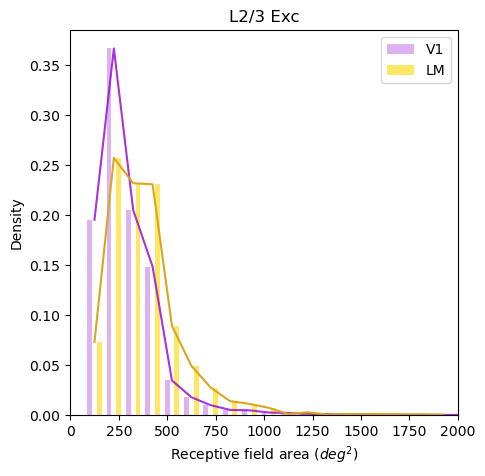

Median V1 RF area: 200.0
Median LM RF area: 300.0

Mean V1 RF area: 271.9705952098648
Mean LM RF area: 352.8386734120292


In [25]:
# Define bin edges and centers
bin_edges = np.arange(-1, 100*100, 50)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate histograms
hist_v1, _ = np.histogram(rf_areas_type_v1, bins=bin_edges)
hist_lm, _ = np.histogram(rf_areas_type_lm, bins=bin_edges)
# hist_v1_dis, _ = np.histogram(rf_areas_type_v1_dis, bins=bin_edges)

# Normalize histograms
hist_v1 = hist_v1 / np.sum(hist_v1)
hist_lm = hist_lm / np.sum(hist_lm)
# hist_v1_dis = hist_v1_dis / np.sum(hist_v1_dis)

# Width of each bar
width = (bin_edges[1] - bin_edges[0]) / 2

# Create bar plots
plt.figure(figsize = (5,5))
plt.bar(bin_centers - width, hist_v1, width=width, color='darkviolet', label='V1', alpha=0.3)
plt.bar(bin_centers + width, hist_lm, width=width, color='gold', label='LM', alpha=0.6)
# plt.bar(bin_centers, hist_v1_dis, width=width, color='indigo', label='V1 disconnected', alpha=0.6)

# Create line plots for non-zero values
plt.plot(bin_centers[hist_v1 > 0], hist_v1[hist_v1 > 0], color='darkviolet', alpha = 0.8)
plt.plot(bin_centers[hist_lm > 0], hist_lm[hist_lm > 0], color='goldenrod')
# plt.plot(bin_centers[hist_v1_dis > 0], hist_v1_dis[hist_v1_dis > 0], color='indigo')

plt.xlabel(r'Receptive field area ($deg^2$)')
plt.ylabel('Density')
plt.xlim(-1, 2000)
# put neuron type as title
plt.title(type)
plt.legend()
plt.show()

# print the medians
print('Median V1 RF area:', np.nanmedian(rf_areas_type_v1))
print('Median LM RF area:', np.nanmedian(rf_areas_type_lm))
# print('Median V1 disconnected RF area:', np.nanmedian(rf_areas_type_v1_dis))

# print the means
print()
print('Mean V1 RF area:', np.nanmean(rf_areas_type_v1))
print('Mean LM RF area:', np.nanmean(rf_areas_type_lm))
# print('Mean V1 disconnected RF area:', np.nanmean(rf_areas_type_v1_dis))

## For all excitatory neurons

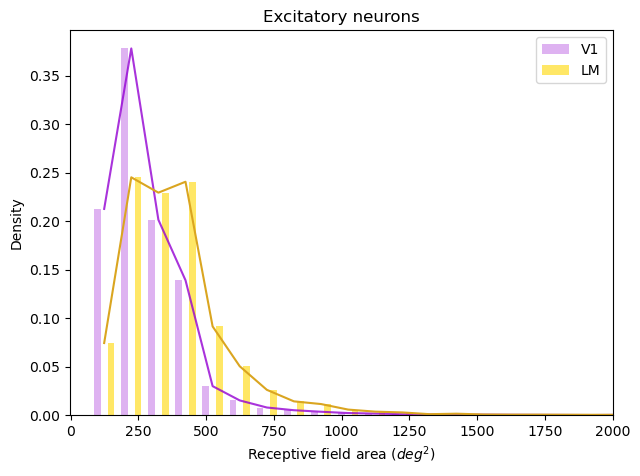

Median V1 RF area: 200.0
Median LM RF area: 300.0

Mean V1 RF area: 259.66546195903993
Mean LM RF area: 358.49087353324643


In [26]:
# Now do it for all excitatory neurons together: L2/3 Exc, L4 Exc, L5 Exc, L6 Exc
types = [1, 5, 9, 13]

rf_areas_exc_v1 = np.zeros((0))
rf_areas_exc_lm = np.zeros((0))
# rf_areas_exc_v1_dis = np.zeros((0))

for t in types:
    rf_areas_exc_v1 = np.concatenate((rf_areas_exc_v1, rf_areas_v1[layer_mask_v1_types[t]]))
    rf_areas_exc_lm = np.concatenate((rf_areas_exc_lm, rf_areas_lm[layer_mask_lm_types[t]]))
    # rf_areas_exc_v1_dis = np.concatenate((rf_areas_exc_v1_dis, rf_areas_v1_dis[layer_mask_v1_types[t]]))

# Define bin edges and centers
bin_edges = np.arange(-1, 100*100, 50)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate histograms
hist_v1, _ = np.histogram(rf_areas_exc_v1, bins=bin_edges)
hist_lm, _ = np.histogram(rf_areas_exc_lm, bins=bin_edges)
# hist_v1_dis, _ = np.histogram(rf_areas_exc_v1_dis, bins=bin_edges)

# Normalize histograms
hist_v1 = hist_v1 / np.sum(hist_v1)
hist_lm = hist_lm / np.sum(hist_lm)
# hist_v1_dis = hist_v1_dis / np.sum(hist_v1_dis)

# Width of each bar
width = (bin_edges[1] - bin_edges[0]) / 2

# Create bar plots
plt.figure(figsize = (7,5))
plt.bar(bin_centers - width, hist_v1, width=width, color='darkviolet', label='V1', alpha=0.3)
plt.bar(bin_centers + width, hist_lm, width=width, color='gold', label='LM', alpha=0.6)
# plt.bar(bin_centers, hist_v1_dis, width=width, color='indigo', label='V1 disconnected', alpha=0.6)

# Create line plots for non-zero values
plt.plot(bin_centers[hist_v1 > 0], hist_v1[hist_v1 > 0], color='darkviolet', alpha = 0.8)
plt.plot(bin_centers[hist_lm > 0], hist_lm[hist_lm > 0], color='goldenrod')
# plt.plot(bin_centers[hist_v1_dis > 0], hist_v1_dis[hist_v1_dis > 0], color='indigo')

plt.xlabel(r'Receptive field area ($deg^2$)')
plt.ylabel('Density')
plt.xlim(-1, 2000)
# put neuron type as title
plt.title('Excitatory neurons')
plt.legend()

# # compute quartile 1 and 3
# q1_v1 = np.percentile(rf_areas_exc_v1, 5)
# q3_v1 = np.percentile(rf_areas_exc_v1, 95)
# q1_lm = np.percentile(rf_areas_exc_lm, 5)
# q3_lm = np.percentile(rf_areas_exc_lm, 95)
# q1_v1dis = np.percentile(rf_areas_exc_v1_dis, 5)
# q3_v1dis = np.percentile(rf_areas_exc_v1_dis, 95)

plt.show()

# print medians
print('Median V1 RF area:', np.nanmedian(rf_areas_exc_v1))
print('Median LM RF area:', np.nanmedian(rf_areas_exc_lm))
# print('Median V1 disconnected RF area:', np.nanmedian(rf_areas_exc_v1_dis))

# # print average inside the 1st and 3rd quartile
# print()
# print('Average V1 RF area inside 0.05 and 0.95 percentiles:', np.mean(rf_areas_exc_v1[(rf_areas_exc_v1 > q1_v1) & (rf_areas_exc_v1 < q3_v1)]))
# print('Average LM RF area inside 0.05 and 0.95 percentiles:', np.mean(rf_areas_exc_lm[(rf_areas_exc_lm > q1_lm) & (rf_areas_exc_lm < q3_lm)]))
# print('Average V1 disconnected RF area inside 0.05 and 0.95 percentiles:', np.mean(rf_areas_exc_v1_dis[(rf_areas_exc_v1_dis > q1_v1dis) & (rf_areas_exc_v1_dis < q3_v1dis)]))

# print the means
print()
print('Mean V1 RF area:', np.nanmean(rf_areas_exc_v1))
print('Mean LM RF area:', np.nanmean(rf_areas_exc_lm))
# print('Mean V1 disconnected RF area:', np.nanmean(rf_areas_exc_v1_dis))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


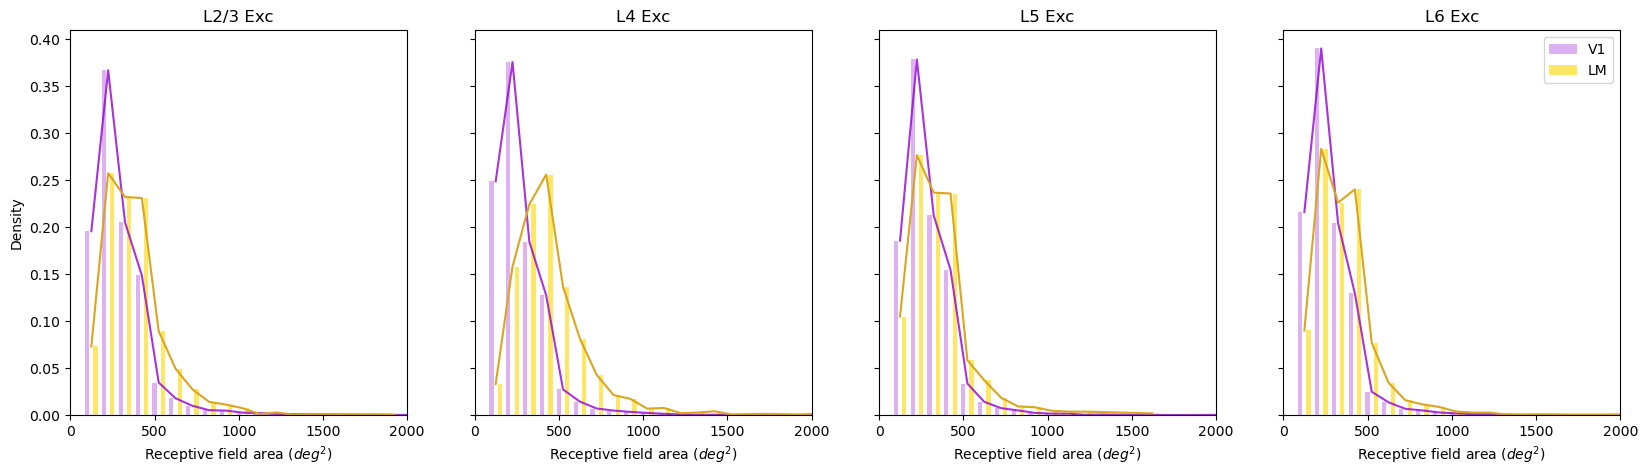

In [27]:
# Now do it for all excitatory neurons together: L2/3 Exc, L4 Exc, L5 Exc, L6 Exc
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

types = [1, 5, 9, 13]

for i, t in enumerate(types):
    rf_areas_exc_v1 = rf_areas_v1[layer_mask_v1_types[t]]
    rf_areas_exc_lm = rf_areas_lm[layer_mask_lm_types[t]]
    # rf_areas_exc_v1_dis = np.concatenate((rf_areas_exc_v1_dis, rf_areas_v1_dis[layer_mask_v1_types[t]]))

    # Define bin edges and centers
    bin_edges = np.arange(-1, 100*100, 50)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Calculate histograms
    hist_v1, _ = np.histogram(rf_areas_exc_v1, bins=bin_edges)
    hist_lm, _ = np.histogram(rf_areas_exc_lm, bins=bin_edges)
    # hist_v1_dis, _ = np.histogram(rf_areas_exc_v1_dis, bins=bin_edges)

    # Normalize histograms
    hist_v1 = hist_v1 / np.sum(hist_v1)
    hist_lm = hist_lm / np.sum(hist_lm)
    # hist_v1_dis = hist_v1_dis / np.sum(hist_v1_dis)

    # Width of each bar
    width = (bin_edges[1] - bin_edges[0]) / 2

    # Create bar plots
    axs[i].bar(bin_centers - width, hist_v1, width=width, color='darkviolet', label='V1', alpha=0.3)
    axs[i].bar(bin_centers + width, hist_lm, width=width, color='gold', label='LM', alpha=0.6)
    # plt.bar(bin_centers, hist_v1_dis, width=width, color='indigo', label='V1 disconnected', alpha=0.6)

    # Create line plots for non-zero values
    axs[i].plot(bin_centers[hist_v1 > 0], hist_v1[hist_v1 > 0], color='darkviolet', alpha = 0.8)
    axs[i].plot(bin_centers[hist_lm > 0], hist_lm[hist_lm > 0], color='goldenrod')
    # plt.plot(bin_centers[hist_v1_dis > 0], hist_v1_dis[hist_v1_dis > 0], color='indigo')

    axs[i].set_xlabel(r'Receptive field area ($deg^2$)')
    axs[i].set_xlim(-1, 2000)
    # put neuron type as title
    axs[i].set_title(f'{unique_cell_types[t]}')
    plt.legend()

axs[0].set_ylabel('Density')
plt.show()

# Null model

## Visualization 1 neuron

Null expected value:  23.3834
One null chi2:  225.430419921875
Chi^2 p-value: 0.001


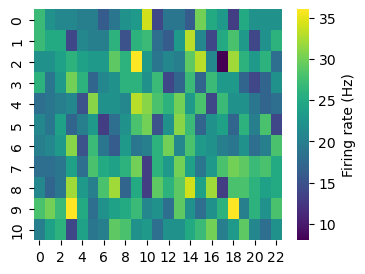

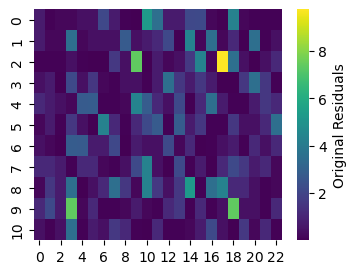

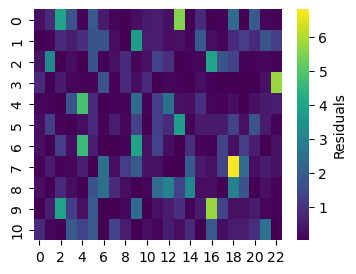

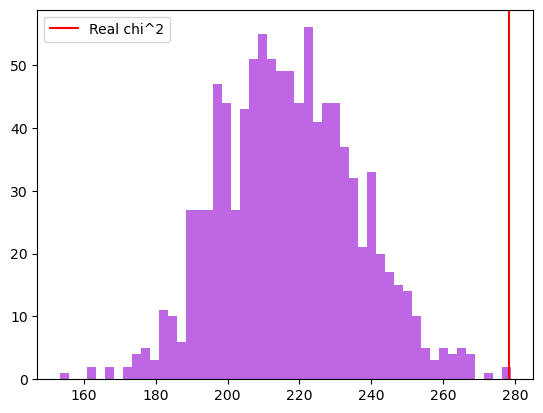

In [33]:
neuron = 2649

epsilon = 1e-6
n_shuffles = 1000
null_chi2_v1 = np.zeros((n_shuffles))
neuron_rf = np.copy(v1_total_spikes[:,:,neuron]) # select the neuron
neuron_rf_trials = v1_spikes[:,:,:,neuron] # select the neuron
n_rows, n_cols, n_trials = neuron_rf_trials.shape
neuron_rf_trials = neuron_rf_trials.flatten()
# set 0.0 values to percentile mean
expected_value = np.mean(neuron_rf)
# print("Expected value: ", expected_value)
# compute residuals
original_residuals = (neuron_rf - expected_value)**2 / (expected_value + epsilon)
real_chi2_v1 = np.sum(original_residuals)
# print("Real chi2: ", real_chi2_v1)

for i in range(n_shuffles):
    # create a matrix to store the shuffled RFs
    bootstrap_sample = np.random.choice(neuron_rf_trials, size=neuron_rf_trials.size, replace=True)
    bootstrap_arr = bootstrap_sample.reshape((n_rows, n_cols, n_trials))
    shuffled_rf = np.sum(bootstrap_arr, axis = 2)
    expected_value = np.mean(shuffled_rf)
    # compute residuals
    residuals = (shuffled_rf - expected_value)**2 / (expected_value)  # Add epsilon to avoid division by zero
    # compute chi^2
    null_chi2_v1[i] = np.sum(residuals)

# compute p-value
p_value_v1 = np.mean(null_chi2_v1 > real_chi2_v1)
print("Null expected value: ", expected_value)
print("One null chi2: ", null_chi2_v1[0])
print('Chi^2 p-value:', p_value_v1)

plt.figure(figsize=(4,3))
sns.heatmap(neuron_rf, cmap='viridis', cbar_kws={'label': 'Firing rate (Hz)'})

plt.figure(figsize=(4,3))
sns.heatmap(original_residuals, cmap='viridis', cbar_kws={'label': 'Original Residuals'})

# plot residuals
plt.figure(figsize=(4,3))
sns.heatmap(residuals, cmap='viridis', cbar_kws={'label': 'Residuals'})

plt.figure()
plt.hist(null_chi2_v1, bins=50, color='darkviolet', alpha=0.6)
plt.axvline(real_chi2_v1, color='red', label='Real chi^2')
plt.legend()
plt.show()

In [41]:
from joblib import Parallel, delayed
import numpy as np
from tqdm import tqdm

def single_neuron_chi2(neuron_index, v1_spikes, indices, epsilon):
    neuron_rf_trials = v1_spikes[:, :, :, neuron_index].reshape(-1).astype(np.float32)
    # Bootstrap
    n_shuffles = indices.shape[0]
    bootstrap_samples = neuron_rf_trials[indices].reshape(n_shuffles, n_rows, n_cols, n_trials)
    # Compute shuffled RFs by averaging over trials
    # shuffled_rf = np.mean(bootstrap_samples, axis=3)
    shuffled_rf = bootstrap_samples.sum(axis=3, dtype=np.float32)
    # Compute the chi-square of every sample
    shuffled_expected = np.mean(shuffled_rf, axis=(1, 2))
    residuals = (shuffled_rf - shuffled_expected[:, np.newaxis, np.newaxis]) ** 2
    shuffled_chi2_v1 = np.sum(
        residuals / (shuffled_expected[:, np.newaxis, np.newaxis] + epsilon),
        axis=(1, 2)
    )

    return shuffled_chi2_v1

def compute_rf_pvalue(spikes, total_spikes, n_shuffles, epsilon):
    n_rows, n_cols, n_neurons = total_spikes.shape
    n_trials = spikes.shape[2]
    sample_size = n_rows * n_cols * n_trials
    # Precompute the real chi^2 for each neuron
    expected = np.mean(total_spikes.astype(np.float32), axis=(0, 1))  # shape: (n_neurons,)
    residuals = (total_spikes - expected[None, None, :]) ** 2
    real_chi2 = np.sum(residuals / (expected[None, None, :] + epsilon), axis=(0,1))
    # Shuffle the trials
    rng = np.random.default_rng()
    indices = rng.integers(0, sample_size, size=(n_shuffles, sample_size))
    # Compute the chi-square of every neuron
    shuffled_chi2 = Parallel(n_jobs=-1)(
        delayed(single_neuron_chi2)(neuron_index, spikes, indices, epsilon)
        for neuron_index in range(n_neurons)
    )
    # Compute the p-value of the RF
    p_value = np.mean(shuffled_chi2 > real_chi2[:, None], axis=1)

    return p_value

In [42]:
n_shuffles = 100

# p_value_lm = compute_rf_pvalue(lm_spikes, lm_total_spikes, n_shuffles, 1e-6)
p_value_v1 = compute_rf_pvalue(v1_spikes, v1_total_spikes, n_shuffles, 1e-6)

In [79]:
conflicting.sum(), np.sum(p_value_v1 < 0.01)

(3744, 1)

In [82]:
conflicting[p_value_v1 < 0.01].sum(), np.arange(51978)[np.logical_and(conflicting, p_value_v1 < 0.01)]

(3744, array([   14,    25,    44, ..., 51807, 51862, 51914]))

In [81]:
np.array(conflicting_inverted_ids)[p_value_v1 < 0.01].sum(), np.arange(51978)[np.logical_and(conflicting_inverted_ids, p_value_v1 < 0.01)]

(1587, array([    5,    11,    59, ..., 51612, 51807, 51820]))

In [70]:
len(inverted_neurons_ids), (p_value_v1 < 0.01)[inverted_neurons_ids].sum()

(6274, 2585)

In [71]:
np.sum(p_value_lm < 0.01), np.sum(p_value_v1 < 0.01)

NameError: name 'p_value_lm' is not defined

In [76]:
# Parameters
epsilon = 1e-6
n_shuffles = 1000
# n_core_neurons_v1 = 100 # Adjust as needed
n_rows, n_cols, n_trials, n_area_neurons = v1_spikes.shape
sample_size = n_rows * n_cols * n_trials

# Initialize p-values
p_values = np.zeros(n_core_neurons_v1)

# Use a random generator for better performance and reuse random indices for all the neurons
rng = np.random.default_rng()
indices = rng.integers(0, sample_size, size=(n_shuffles, sample_size))

# for neuron in range(100):
neuron = 1
# Select the neuron data
neuron_rf = v1_total_spikes[:, :, neuron].astype(np.float32)
neuron_rf_trials = v1_spikes[:, :, :, neuron].reshape(-1).astype(np.float32)

# Compute real chi-squared value
expected_value = np.mean(neuron_rf)
real_residuals = (neuron_rf - expected_value) ** 2 / (expected_value + epsilon)
real_chi2_v1 = np.sum(real_residuals)

# Vectorized random sampling with indices
bootstrap_samples = neuron_rf_trials[indices].reshape(n_shuffles, n_rows, n_cols, n_trials)
# Compute shuffled RFs by averaging over trials
shuffled_rf = np.sum(bootstrap_samples, axis=3)  # Sum over trials
shuffled_expected = np.mean(shuffled_rf, axis=(1, 2))  # Mean over rows and columns
# Compute residuals and chi-squared values for all shuffles
residuals = (shuffled_rf - shuffled_expected[:, np.newaxis, np.newaxis]) ** 2
shuffled_chi2_v1 = np.sum(residuals / (shuffled_expected[:, np.newaxis, np.newaxis] + epsilon), axis=(1, 2))

# shuffled_chi2_v1 = single_neuron_chi2(neuron, v1_spikes, indices, epsilon)
# Compute p-value
p_value_v1 = np.mean(shuffled_chi2_v1 > real_chi2_v1)
p_values[neuron] = p_value_v1

## Null model all neurons

In [92]:
# print amount of neurons with p-value < 0.05
percentage_v1 = np.sum(p_value_v1 < 0.05) / n_core_neurons_v1
percentage_lm = np.sum(p_value_lm < 0.05) / n_core_neurons_lm
# percentage_v1_dis = np.sum(p_value_v1_dis < 0.05) / n_core_neurons_v1

print('Percentage of V1 neurons with p-value < 0.05:', percentage_v1)
print('Percentage of LM neurons with p-value < 0.05:', percentage_lm)
# print('Percentage of V1 disconnected neurons with p-value < 0.05:', percentage_v1_dis)

# print amount of neurons with p-value < 0.01
percentage_v1 = np.sum(p_value_v1 < 0.01) / n_core_neurons_v1
percentage_lm = np.sum(p_value_lm < 0.01) / n_core_neurons_lm
# percentage_v1_dis = np.sum(p_value_v1_dis < 0.01) / n_core_neurons_v1

print('\n Percentage of V1 neurons with p-value < 0.01:', percentage_v1)
print('Percentage of LM neurons with p-value < 0.01:', percentage_lm)
# print('Percentage of V1 disconnected neurons with p-value < 0.01:', percentage_v1_dis)

# select significant neurons as p-value < p_value_th and rf_area < 2500
p_value_th = 0.01
significant_neurons_v1 = np.where((p_value_v1 < p_value_th) & (rf_areas_v1 < 2500) & (rf_areas_v1 > 0))[0]
significant_neurons_lm = np.where((p_value_lm < p_value_th) & (rf_areas_lm < 2500) & (rf_areas_lm > 0))[0]
# significant_neurons_v1_dis = np.where((p_value_v1_dis < p_value_th) & (rf_areas_v1_dis < 2500) & (rf_areas_v1_dis > 0))[0]

# print the percentages of significant neurons
percentage_v1 = len(significant_neurons_v1) / n_core_neurons_v1
percentage_lm = len(significant_neurons_lm) / n_core_neurons_lm
# percentage_v1_dis = len(significant_neurons_v1_dis) / n_core_neurons_v1

print('\n Percentage of V1 neurons with p-value < 0.01 and RF area < 2500:', percentage_v1)
print('Percentage of LM neurons with p-value < 0.01 and RF area < 2500:', percentage_lm)
# print('Percentage of V1 disconnected neurons with p-value < 0.01 and RF area < 2500:', percentage_v1_dis)

Percentage of V1 neurons with p-value < 0.05: 0.4903805456154527
Percentage of LM neurons with p-value < 0.05: 0.3730779606150526

 Percentage of V1 neurons with p-value < 0.01: 0.4582708068798338
Percentage of LM neurons with p-value < 0.01: 0.3269490153763151

 Percentage of V1 neurons with p-value < 0.01 and RF area < 2500: 0.45550040401708414
Percentage of LM neurons with p-value < 0.01 and RF area < 2500: 0.3226328567574858


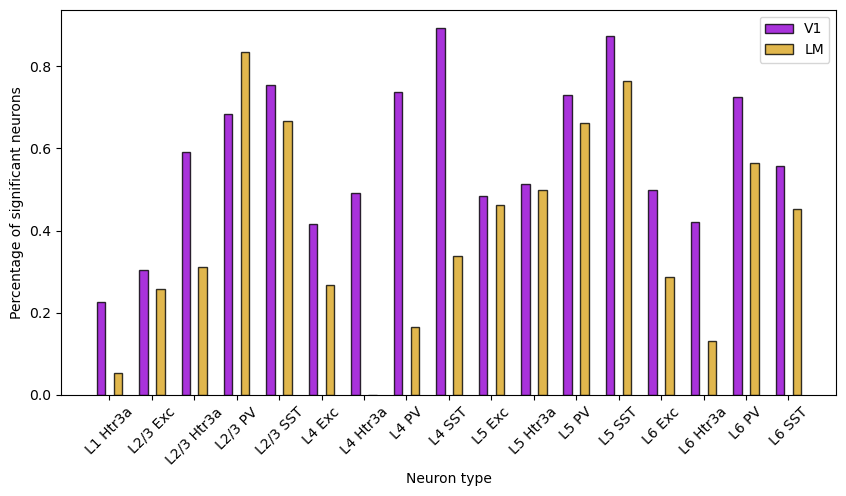

In [93]:
# apply it also to the neuron types
significant_cell_types_v1 = [cell_types_v1[neuron] for neuron in significant_neurons_v1]
significant_cell_types_lm = [cell_types_lm[neuron] for neuron in significant_neurons_lm]
# significant_cell_types_v1_dis = [cell_types_v1[neuron] for neuron in significant_neurons_v1_dis]

# compute the percentage of significant neurons in each neuron type
percentage_v1 = np.zeros(len(unique_cell_types))
percentage_lm = np.zeros(len(unique_cell_types))
# percentage_v1_dis = np.zeros(len(unique_cell_types))

for type in unique_cell_types:
    # count number of type in cell_types_v1
    n_type_v1 = cell_types_v1.count(type)
    n_type_lm = cell_types_lm.count(type)
    # n_type_v1_dis = cell_types_v1.count(type)

    # count number of type in significant_cell_types_v1
    n_type_significant_v1 = significant_cell_types_v1.count(type)
    n_type_significant_lm = significant_cell_types_lm.count(type)
    # n_type_significant_v1_dis = significant_cell_types_v1_dis.count(type)

    # compute the percentage
    percentage_v1[unique_cell_types.index(type)] = n_type_significant_v1 / n_type_v1
    percentage_lm[unique_cell_types.index(type)] = n_type_significant_lm / n_type_lm
    # percentage_v1_dis[unique_cell_types.index(type)] = n_type_significant_v1_dis / n_type_v1_dis


# plot the percentage of significant neurons in each neuron type
plt.figure(figsize = (10,5))
bar_width = 0.2  # Define the width of the bars
x = np.arange(len(unique_cell_types))  # Define the x-coordinates of the bars

plt.bar(x - bar_width, percentage_v1, bar_width, color='darkviolet', label='V1', alpha=0.8, edgecolor='black')
plt.bar(x + bar_width, percentage_lm, bar_width, color='goldenrod', label='LM', alpha=0.8, edgecolor='black')
# plt.bar(x , percentage_v1_dis, bar_width, color='indigo', label='V1 Dis', alpha=0.8, edgecolor='black')

plt.xticks(x, unique_cell_types, rotation=45)   # Set the x-ticks to the middle of the bars
plt.xlabel('Neuron type')
plt.ylabel('Percentage of significant neurons')
plt.legend()
plt.show()

In [64]:
# add column of significant neurons to the dataframes
df_v1['Significant_RF'] = df_v1.index.isin(significant_neurons_v1)
df_lm['Significant_RF'] = df_lm.index.isin(significant_neurons_lm)

# save as v1_features_rf.csv and lm_features_rf.csv
df_v1.to_csv('v1_features_rf.csv')
df_lm.to_csv('lm_features_rf.csv')

# RF computation for all significant neurons

Text(0.5, 0.98, 'V1 neurons RF center and visual coordinates')

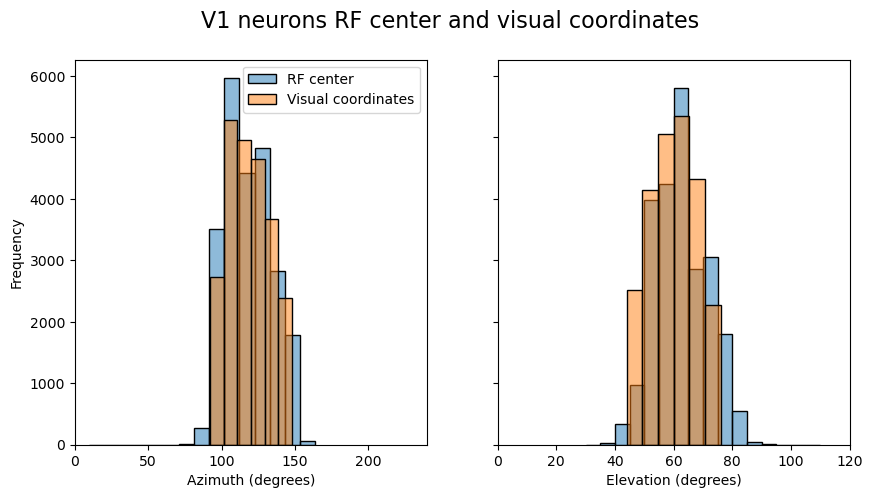

In [99]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# plot the displacement in azimuth in the receptive field center with respect to the visual coordinates
sns.histplot(np.array(center_of_mass_v1)[significant_neurons_v1, 0], binwidth=10, ax=axs[0], alpha=0.5, label='RF center')
sns.histplot(np.array(v1_visual_coordinates)[significant_neurons_v1, 0], binwidth=10, ax=axs[0], alpha=0.5, label='Visual coordinates')
axs[0].set_xlabel('Azimuth (degrees)')
axs[0].set_ylabel('Frequency')
axs[0].set_xlim(0, 240)
axs[0].legend()

# plot the displacement in elevation in the receptive field center with respect to the visual coordinates
sns.histplot(np.array(center_of_mass_v1)[significant_neurons_v1, 1], binwidth=5, ax=axs[1], alpha=0.5)
sns.histplot(np.array(v1_visual_coordinates[significant_neurons_v1, 1]), binwidth=5, ax=axs[1], alpha=0.5)
axs[1].set_xlabel('Elevation (degrees)')
axs[1].set_ylabel('Frequency')
axs[1].set_xlim(0, 120)

# set title
fig.suptitle('V1 neurons RF center and visual coordinates', fontsize=16)

Text(0.5, 0.98, 'LM neurons RF center and visual coordinates')

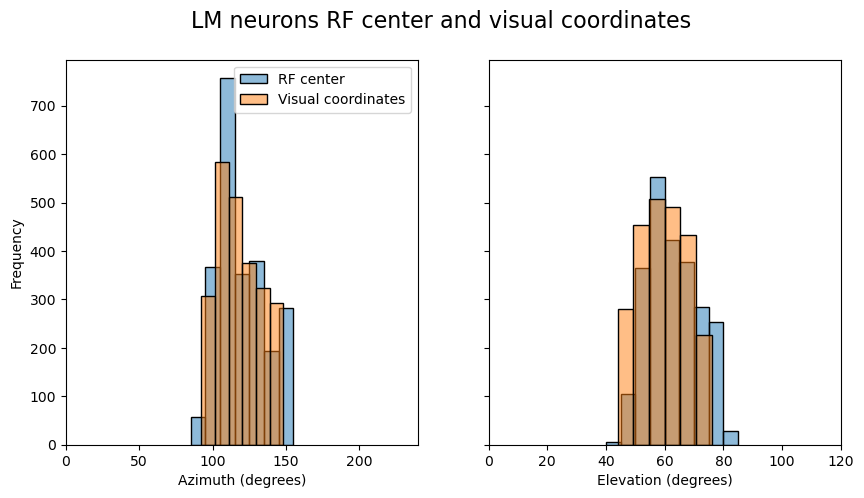

In [100]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# plot the displacement in azimuth in the receptive field center with respect to the visual coordinates
sns.histplot(np.array(center_of_mass_lm)[significant_neurons_lm, 0], binwidth=10, ax=axs[0], alpha=0.5, label='RF center')
sns.histplot(np.array(lm_visual_coordinates)[significant_neurons_lm, 0], binwidth=10, ax=axs[0], alpha=0.5, label='Visual coordinates')
axs[0].set_xlabel('Azimuth (degrees)')
axs[0].set_ylabel('Frequency')
axs[0].set_xlim(0, 240)
axs[0].legend()

# plot the displacement in elevation in the receptive field center with respect to the visual coordinates
sns.histplot(np.array(center_of_mass_lm)[significant_neurons_lm, 1], binwidth=5, ax=axs[1], alpha=0.5)
sns.histplot(np.array(lm_visual_coordinates[significant_neurons_lm, 1]), binwidth=5, ax=axs[1], alpha=0.5)
axs[1].set_xlabel('Elevation (degrees)')
axs[1].set_ylabel('Frequency')
axs[1].set_xlim(0, 120)

# set title
fig.suptitle('LM neurons RF center and visual coordinates', fontsize=16)

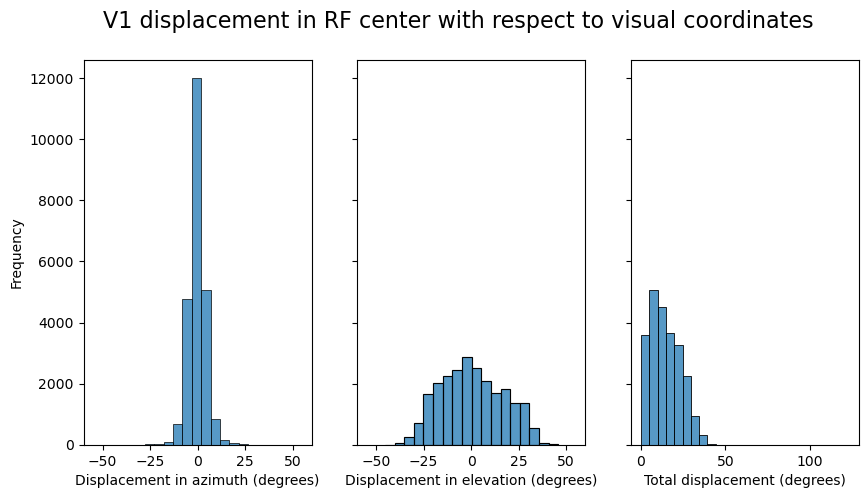

In [102]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5), sharey=True)

# plot the displacement in azimuth in the receptive field center with respect to the visual coordinates
displacement_azimuth = np.array(center_of_mass_v1)[significant_neurons_v1, 0] - np.array(v1_visual_coordinates)[significant_neurons_v1, 0]
sns.histplot(displacement_azimuth, binwidth=5, ax=axs[0])
axs[0].set_xlabel('Displacement in azimuth (degrees)')
axs[0].set_ylabel('Frequency')
axs[0].set_xlim(-60, 60)

# plot the displacement in elevation in the receptive field center with respect to the visual coordinates
displacement_elevation = np.array(center_of_mass_v1)[significant_neurons_v1, 1] - np.array(v1_visual_coordinates)[significant_neurons_v1, 1]
sns.histplot(displacement_elevation, binwidth=5, ax=axs[1])
axs[1].set_xlabel('Displacement in elevation (degrees)')
axs[1].set_ylabel('Frequency')
axs[1].set_xlim(-60, 60)

# plot the total distance between the receptive field center and the visual coordinates
displacement = np.sqrt(displacement_azimuth**2 + displacement_elevation**2)
sns.histplot(displacement, binwidth=5, ax=axs[2])
axs[2].set_xlabel('Total displacement (degrees)')
axs[2].set_ylabel('Frequency')

fig.suptitle('V1 displacement in RF center with respect to visual coordinates', fontsize=16)
plt.show()

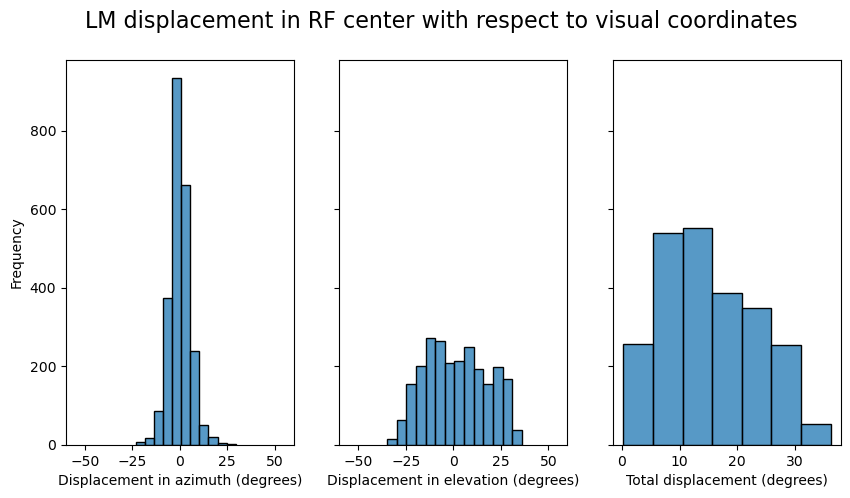

In [103]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5), sharey=True)

# plot the displacement in azimuth in the receptive field center with respect to the visual coordinates
displacement_azimuth = np.array(center_of_mass_lm)[significant_neurons_lm, 0] - np.array(lm_visual_coordinates)[significant_neurons_lm, 0]
sns.histplot(displacement_azimuth, binwidth=5, ax=axs[0])
axs[0].set_xlabel('Displacement in azimuth (degrees)')
axs[0].set_ylabel('Frequency')
axs[0].set_xlim(-60, 60)

# plot the displacement in elevation in the receptive field center with respect to the visual coordinates
displacement_elevation = np.array(center_of_mass_lm)[significant_neurons_lm, 1] - np.array(lm_visual_coordinates)[significant_neurons_lm, 1]
sns.histplot(displacement_elevation, binwidth=5, ax=axs[1])
axs[1].set_xlabel('Displacement in elevation (degrees)')
axs[1].set_ylabel('Frequency')
axs[1].set_xlim(-60, 60)

# plot the total distance between the receptive field center and the visual coordinates
displacement = np.sqrt(displacement_azimuth**2 + displacement_elevation**2)
sns.histplot(displacement, binwidth=5, ax=axs[2])
axs[2].set_xlabel('Total displacement (degrees)')
axs[2].set_ylabel('Frequency')

fig.suptitle('LM displacement in RF center with respect to visual coordinates', fontsize=16)
plt.show()

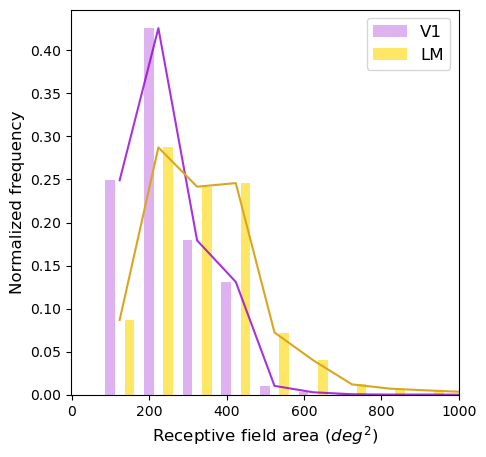

Median V1 RF area: 200.0
Median LM RF area: 300.0

Mean V1 RF area: 224.5184997465788
Mean LM RF area: 317.809364548495


In [ ]:
# Define bin edges and centers
bin_edges = np.arange(-1, 100*100, 50)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Filter the rf_areas_v1 and rf_areas_lm with the significant neurons
rf_areas_v1_significant = rf_areas_v1[significant_neurons_v1]
rf_areas_lm_significant = rf_areas_lm[significant_neurons_lm]
# rf_areas_v1_dis_significant = rf_areas_v1_dis[significant_neurons_v1_dis]

# Calculate histograms
hist_v1, _ = np.histogram(rf_areas_v1_significant, bins=bin_edges)
hist_lm, _ = np.histogram(rf_areas_lm_significant, bins=bin_edges)
# hist_v1_dis, _ = np.histogram(rf_areas_v1_dis_significant, bins=bin_edges)

# Normalize histograms
hist_v1 = hist_v1 / np.sum(hist_v1)
hist_lm = hist_lm / np.sum(hist_lm)
# hist_v1_dis = hist_v1_dis / np.sum(hist_v1_dis)

# Width of each bar
width = (bin_edges[1] - bin_edges[0]) / 2

# Create bar plots
plt.figure(figsize = (5,5))
plt.bar(bin_centers - width, hist_v1, width=width, color='darkviolet', label='V1', alpha=0.3)
plt.bar(bin_centers + width, hist_lm, width=width, color='gold', label='LM', alpha=0.6)
# plt.bar(bin_centers, hist_v1_dis, width=width, color='indigo', label='V1 disconnected', alpha=0.6)

# Create line plots for non-zero values
plt.plot(bin_centers[hist_v1 > 0], hist_v1[hist_v1 > 0], color='darkviolet', alpha = 0.8)
plt.plot(bin_centers[hist_lm > 0], hist_lm[hist_lm > 0], color='goldenrod')
# plt.plot(bin_centers[hist_v1_dis > 0], hist_v1_dis[hist_v1_dis > 0], color='indigo')

plt.xlabel(r'Receptive field area ($deg^2$)', fontsize=12)
plt.ylabel('Normalized frequency', fontsize=12)
plt.xlim(-1, 1000)
plt.legend(fontsize = 12)

plt.show()

# compute the median
median_v1 = np.median(rf_areas_v1_significant)
median_lm = np.median(rf_areas_lm_significant)
# median_v1dis = np.median(rf_areas_v1_dis_significant)

print('Median V1 RF area:', median_v1)
print('Median LM RF area:', median_lm)
# print('Median V1 disconnected RF area:', median_v1dis)

# compute the mean
mean_v1 = np.mean(rf_areas_v1_significant)
mean_lm = np.mean(rf_areas_lm_significant)
# mean_v1dis = np.mean(rf_areas_v1_dis_significant)

print()
print('Mean V1 RF area:', mean_v1)
print('Mean LM RF area:', mean_lm)
# print('Mean V1 disconnected RF area:', mean_v1dis)

(-1.0, 1500.0)

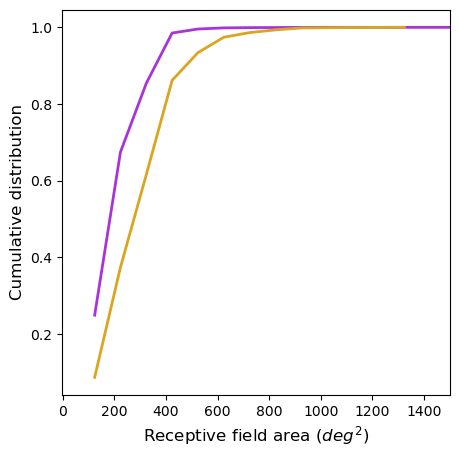

In [96]:
# Define bin edges and centers
plt.figure(figsize=(5,5))
bin_edges = np.arange(-1, 100*100, 50)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate histograms
hist_v1, _ = np.histogram(rf_areas_v1_significant, bins=bin_edges)
hist_lm, _ = np.histogram(rf_areas_lm_significant, bins=bin_edges)
# hist_v1_dis, _ = np.histogram(rf_areas_v1_dis_significant, bins=bin_edges)

# Normalize histograms
hist_v1 = hist_v1 / np.sum(hist_v1)
hist_lm = hist_lm / np.sum(hist_lm)
# hist_v1_dis = hist_v1_dis / np.sum(hist_v1_dis)

# Calculate cumulative sums
cumsum_v1 = np.cumsum(hist_v1)
cumsum_lm = np.cumsum(hist_lm)
# cumsum_v1_dis = np.cumsum(hist_v1_dis)

# Width of each bar
width = (bin_edges[1] - bin_edges[0]) / 2

# Create line plots for non-zero values
plt.plot(bin_centers[hist_v1 > 0], cumsum_v1[hist_v1 > 0], color='darkviolet', alpha = 0.8, linewidth = 2)
plt.plot(bin_centers[hist_lm > 0], cumsum_lm[hist_lm > 0], color='goldenrod', linewidth = 2)
# plt.plot(bin_centers[hist_v1_dis > 0], cumsum_v1_dis[hist_v1_dis > 0], color='indigo', linewidth = 2)

plt.xlabel(r'Receptive field area ($deg^2$)', fontsize = 12)
plt.ylabel('Cumulative distribution', fontsize = 12)
plt.xlim(-1, 1500)
# plt.legend()

In [105]:
def get_bootstrap_95ci(M, measure_of_central_tendency, N=1000):
    n = int(len(M)/2)
    est = np.zeros((N,))
    for i in range(N):
        boot = M[np.random.permutation(len(M))[:n]]
        est[i] = measure_of_central_tendency(boot)
        
    return np.percentile(est,97.5) - np.nanmean(est)

# compute the 95% confidence interval for the mean
ci_v1 = get_bootstrap_95ci(rf_areas_v1_significant, np.mean)
ci_lm = get_bootstrap_95ci(rf_areas_lm_significant, np.mean)
# ci_v1_dis = get_bootstrap_95ci(rf_areas_v1_dis_significant, np.mean)

print()
print('95% confidence interval for the mean V1:', ci_v1)
print('95% confidence interval for the mean LM:', ci_lm)
# print('95% confidence interval for the mean V1 disconnected:', ci_v1_dis)


95% confidence interval for the mean V1: 1.3607197161682905
95% confidence interval for the mean LM: 6.157608695652243


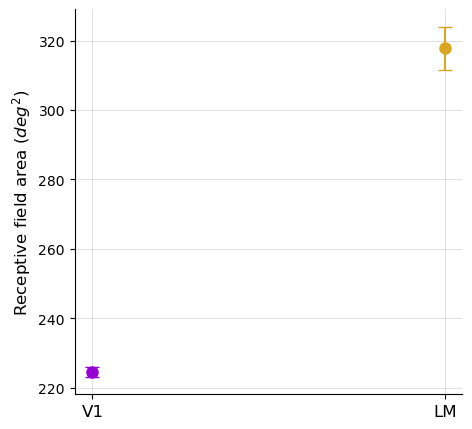

In [106]:
# Create a figure
plt.figure(figsize=(5,5))
# x = ["V1 disconnected", "V1", "LM"]
# colors = ['indigo', 'darkviolet', 'goldenrod']
# y = [mean_v1dis, mean_v1, mean_lm]
# errors = [ci_v1, ci_v1_dis, ci_lm]
x = ["V1", "LM"]
colors = ['darkviolet', 'goldenrod']
y = [mean_v1, mean_lm]
errors = [ci_v1, ci_lm]

for i in range(len(x)):
    plt.errorbar(x[i], y[i], yerr=errors[i], fmt='o', capsize=5, markersize=8, color=colors[i])

plt.ylabel(r'Receptive field area ($deg^2$)', fontsize = 12)

# Add a light grey grid
plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)
# Remove top and right axes
ax = plt.gca()  # gca stands for 'get current axis'
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xticks(fontsize = 12)

plt.show()

## RF significant neurons by types

In [79]:
# update the layers mask to include only significant neurons
layer_mask_v1_types_significant = [[cell_type == unique_cell_types[i] for cell_type in significant_cell_types_v1] for i in range(len(unique_cell_types))]
layer_mask_lm_types_significant = [[cell_type == unique_cell_types[i] for cell_type in significant_cell_types_lm] for i in range(len(unique_cell_types))]
layer_mask_v1dis_types_significant = [[cell_type == unique_cell_types[i] for cell_type in significant_cell_types_v1_dis] for i in range(len(unique_cell_types))]

# Select the neuron type to filter
t = 1
type = unique_cell_types[t]
print("You have selected the type: ", type)

# select the given neuron type receptive field
rf_areas_type_v1_significant = rf_areas_v1_significant[layer_mask_v1_types_significant[t]]
rf_areas_type_lm_significant = rf_areas_lm_significant[layer_mask_lm_types_significant[t]]
rf_areas_type_v1dis_significant = rf_areas_v1_dis_significant[layer_mask_v1dis_types_significant[t]]

You have selected the type:  L2/3 Exc


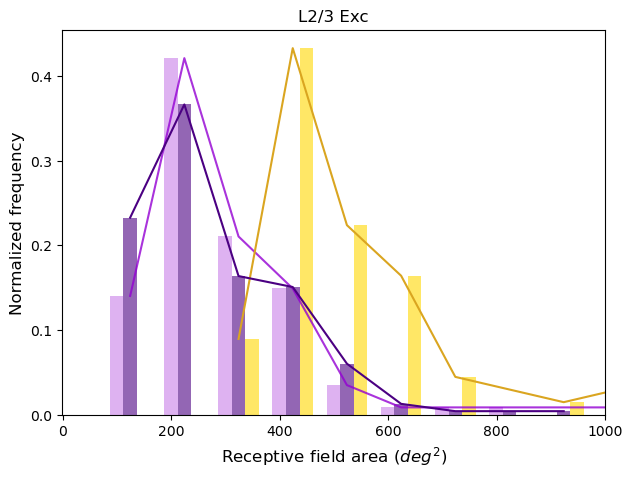

Median V1 RF area: 200.0
Median LM RF area: 400.0
Median V1 disconnected RF area: 200.0
Mean V1 RF area: 277.1929824561403
Mean LM RF area: 485.07462686567163
Mean V1 disconnected RF area: 254.31034482758622


In [80]:
# Define bin edges and centers
bin_edges = np.arange(-1, 100*100, 50)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate histograms
hist_v1, _ = np.histogram(rf_areas_type_v1_significant, bins=bin_edges)
hist_lm, _ = np.histogram(rf_areas_type_lm_significant, bins=bin_edges)
hist_v1_dis, _ = np.histogram(rf_areas_type_v1dis_significant, bins=bin_edges)

# Normalize histograms
hist_v1 = hist_v1 / np.sum(hist_v1)
hist_lm = hist_lm / np.sum(hist_lm)
hist_v1_dis = hist_v1_dis / np.sum(hist_v1_dis)

# Width of each bar
width = (bin_edges[1] - bin_edges[0]) / 2

# Create bar plots
plt.figure(figsize = (7,5))
plt.bar(bin_centers - width, hist_v1, width=width, color='darkviolet', label='V1', alpha=0.3)
plt.bar(bin_centers + width, hist_lm, width=width, color='gold', label='LM', alpha=0.6)
plt.bar(bin_centers, hist_v1_dis, width=width, color='indigo', label='V1 disconnected', alpha=0.6)

# Create line plots for non-zero values
plt.plot(bin_centers[hist_v1 > 0], hist_v1[hist_v1 > 0], color='darkviolet', alpha = 0.8)
plt.plot(bin_centers[hist_lm > 0], hist_lm[hist_lm > 0], color='goldenrod')
plt.plot(bin_centers[hist_v1_dis > 0], hist_v1_dis[hist_v1_dis > 0], color='indigo')

plt.xlabel(r'Receptive field area ($deg^2$)', fontsize = 12)
plt.ylabel('Normalized frequency', fontsize = 12)
plt.xlim(-1, 1000)
# put neuron type as title
plt.title(type)
# plt.legend()

plt.show()

# print the medians
print('Median V1 RF area:', np.median(rf_areas_type_v1_significant))
print('Median LM RF area:', np.median(rf_areas_type_lm_significant))
print('Median V1 disconnected RF area:', np.median(rf_areas_type_v1dis_significant))

# print the means
print('Mean V1 RF area:', np.mean(rf_areas_type_v1_significant))
print('Mean LM RF area:', np.mean(rf_areas_type_lm_significant))
print('Mean V1 disconnected RF area:', np.mean(rf_areas_type_v1dis_significant))